In [1]:
import numpy as np
import xarray as xr
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import keras_tuner as kt  # make sure you have keras-tuner installed
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import xgboost as xgb

# Ciclostationary mean and variance with moving average
def m_mean_variance(data):
    m_means = np.full(12, np.nan)
    m_variances = np.full (12, np.nan)
    last_col = data[:, -1].reshape(-1, 1)
    first_col = data[:, 0].reshape(-1, 1)
    new_data = np.hstack((last_col, data, first_col))  
    for i in range(data.shape[1]):
        obj = new_data[:, i:i+3]
        m_means[i] = np.mean(obj)
        m_variances[i] = np.var(obj)
    return m_means, m_variances

# Min-max normalization
def normalize_data(data, mins=None, maxs=None):
    # Create a mask for NaN values
    nan_mask = np.isnan(data)
    train_mins = []
    train_maxs = []
    # Initialize an array to store the normalized data
    normalized_data = np.zeros_like(data)

    # Loop through each variable (last dimension in your data)
    for var_idx in range(data.shape[-1]):
        # Extract the variable array
        var_data = data[..., var_idx]

        # Find the min and max, ignoring NaNs
        if mins == None:
            min_val = np.nanmin(var_data)
            train_mins.append(min_val)
            max_val = np.nanmax(var_data)
            train_maxs.append(max_val)
        else:
            min_val = mins[var_idx]
            max_val = maxs[var_idx]
        # Normalize the data to [0, 1], ignoring NaNs
        normalized_data[..., var_idx] = (var_data - min_val) / (max_val - min_val)

    # Replace NaNs with -0.1
    normalized_data[nan_mask] = -0.1
    return normalized_data, train_mins, train_maxs

def err_func(power):
    def _err_func(y_true, y_pred):
        return tf.reduce_mean(tf.abs(y_true - y_pred) ** power)
    return _err_func

C:\Users\guido\anaconda3\envs\keras_tuner_cartopy\lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Inputs

In [2]:
x = np.load('data/stacked.npy')
x, train_mins, train_maxs = normalize_data(x)

ace_orig = np.load('data/ace.npy').flatten()
# #Ciclostationary means and variances with moving average
# mmeans, mvar = m_mean_variance(ace)

# mn = np.tile(mmeans, (40, 1))
# sn = np.tile(np.sqrt(mvar), (40,1))
# ran = np.arange(len(mvar))  
# upper_bound = mmeans + np.sqrt(mvar)
# lower_bound = mmeans - np.sqrt(mvar)

# # Removing seasonalization 
# m = np.tile(mmeans, (40, 1)) #Create an array with 40 times the values of mean and st. deviation
# s = np.tile(np.sqrt(mvar), (40,1))
#ace = (ace-m)/s

y = ace_orig

# roll data forward so that they align with the cyclonic season
# shift = 6  # if index 0 corresponds to January, then index 6 is July.
# x = np.roll(x, -shift, axis=0)
# y = np.roll(y, -shift, axis=0)

### Benchmark

SARIMA Benchmark -- MSE: 0.0259, Pearson R: 0.3420


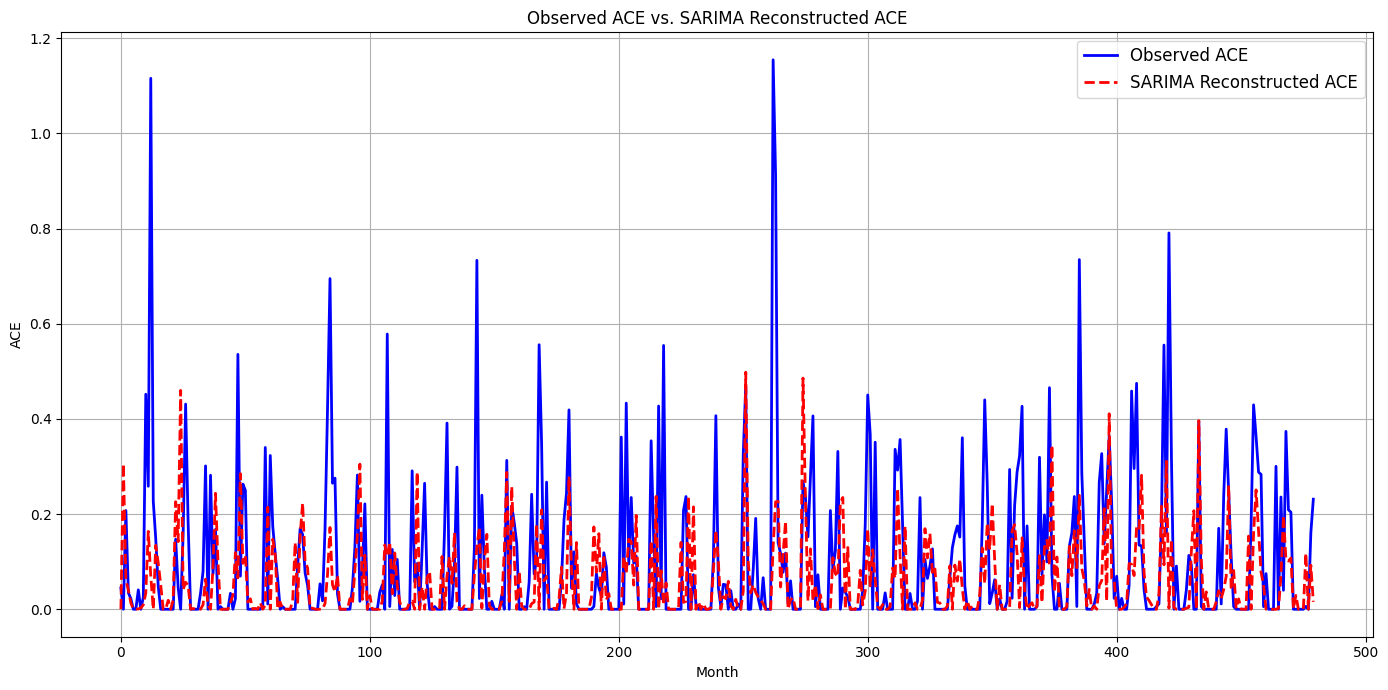

In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

# Assume your ACE time series is stored in a NumPy array of shape (480,)
# For demonstration, we create a synthetic ACE series with a clear seasonal pattern:
np.random.seed(42)
months = np.arange(480)
# Construct a seasonal signal (period=12) plus noise

# We'll reconstruct the ACE series using leave-one-year-out (LOY) cross-validation
predictions_sarima = np.empty_like(ace_orig, dtype=float)
years = 40  # 480 months / 12 = 40 years

for year in range(years):
    # Define test indices: one full year (12 months)
    start = year * 12
    end = start + 12
    test_indices = np.arange(start, end)
    # Use all other months as training data
    train_indices = np.setdiff1d(np.arange(480), test_indices)
    
    y_train = ace_orig[train_indices]
    
    # Fit a SARIMA model on the training data.
    # Here, we choose order=(1,0,0) and seasonal_order=(1,0,0,12) as a starting point.
    try:
        model = SARIMAX(y_train, order=(1, 0, 0), seasonal_order=(1, 0, 0, 12))
        model_fit = model.fit(disp=False)
        # Forecast for the 12 test months
        forecast = model_fit.predict(start=test_indices[0], end=test_indices[-1])
    except Exception as e:
        print(f"Error in SARIMA model for year {year}: {e}")
        forecast = np.full(len(test_indices), np.nan)
    
    predictions_sarima[test_indices] = forecast

predictions_sarima[predictions_sarima<0] = 0

# Evaluate performance for SARIMA
mse_sarima = mean_squared_error(ace_orig, predictions_sarima)
r_sarima, _ = pearsonr(ace_orig, predictions_sarima)
print(f"SARIMA Benchmark -- MSE: {mse_sarima:.4f}, Pearson R: {r_sarima:.4f}")

# Plot the reconstructed ACE curve vs. the original ACE timeseries
plt.figure(figsize=(14, 7))
plt.plot(np.arange(480), ace_orig, label="Observed ACE", color="blue", linewidth=2)
plt.plot(np.arange(480), predictions_sarima, label="SARIMA Reconstructed ACE", color="red", linestyle="--", linewidth=2)
plt.xlabel("Month")
plt.ylabel("ACE")
plt.title("Observed ACE vs. SARIMA Reconstructed ACE")
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
def quantile_weighted_mse(quantile_values, min_weight=0.1):
    """
    Creates a quantile-weighted MSE loss function with fixed quantile values.
    
    Args:
        quantile_values: Pre-computed quantile boundary values for the entire dataset.
                        Should be a sorted 1D array or tensor.
        min_weight: Minimum weight for the lowest quantile (default: 0.1)
    
    Returns:
        A loss function that takes y_true and y_pred as arguments
    """
    # Convert and store quantile values as a 1D tensor
    quantile_values = tf.constant(quantile_values, dtype=tf.float32)
    num_quantiles = len(quantile_values) - 1
    
    # Pre-compute weights array as a 1D tensor
    quantile_weights = tf.constant(np.linspace(min_weight, 1.0, num_quantiles), dtype=tf.float32)
    
    def loss_fn(y_true, y_pred):
        """
        Calculate MSE weighted by quantiles of y_true values.
        
        Args:
            y_true: True values
            y_pred: Predicted values
        
        Returns:
            Weighted MSE value
        """
        # Convert inputs to tensors
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # Flatten the inputs
        y_true_flat = tf.reshape(y_true, [-1])
        y_pred_flat = tf.reshape(y_pred, [-1])
        
        # For each value in y_true, count how many quantile values it's greater than
        # This gives us the quantile index for each value
        quantile_indices = tf.reduce_sum(
            tf.cast(tf.expand_dims(y_true_flat, -1) >= quantile_values[:-1], tf.int32),
            axis=-1
        )
        
        # Clip indices to valid range
        quantile_indices = tf.clip_by_value(quantile_indices, 0, num_quantiles - 1)
        
        # Get weight for each y_true value
        weights = tf.gather(quantile_weights, quantile_indices)
        
        # Calculate weighted squared errors
        squared_errors = tf.square(y_true_flat - y_pred_flat)
        weighted_squared_errors = squared_errors * weights
        
        # Return mean of weighted squared errors
        return tf.reduce_mean(weighted_squared_errors)
    return loss_fn

num_quantiles = 10
quantiles = np.linspace(0, 100, num_quantiles + 1)
quantile_values = np.percentile(y, quantiles)

# Create the metric with pre-computed quantiles
qMSE = quantile_weighted_mse(quantile_values=quantile_values, min_weight=0.1)

### Joint hyperparameter optimization via nested LOOV (k = # of years)

In [5]:
# ---------------------------
# 1. Define the model builder
# ---------------------------
def build_model(hp, is_dict=False):
    """
    Build a shallow CNN whose hyperparameters include:
      - Which input channels to use (from 10 candidates)
      - Number of convolutional layers (1 to 3)
      - Number of filters (choose from 16, 32, 64, 128)
      - Dropout rate (0.0 to 0.5 in steps of 0.1)
      - Learning rate (1e-4 to 1e-2, log-uniform)
    """
    if is_dict:
        # If hp is a dictionary, just read the values directly
        num_conv_layers = hp['num_conv_layers']
        filters = hp['filters']
        dropout_rate = hp['dropout_rate']
        learning_rate = hp['learning_rate']
        loss = hp['loss_func']
        
        # Get the feature selection configuration
        selected_indices = []
        for i in range(10):
            if hp.get(f'use_feature_{i}', True):  # default to True if not specified
                selected_indices.append(i)
        if len(selected_indices) == 0:
            selected_indices = [0]
    else:
        num_conv_layers = hp.Int('num_conv_layers', min_value=1, max_value=4, default=1)
        filters = hp.Choice('filters', values=[16, 32, 64, 128], default=32)
        dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1, default=0.25)
        learning_rate = hp.Float('learning_rate', 1e-5, 1e-2, sampling='log', default=1e-3)
        loss = hp.Choice('loss_func', values=['mae', 'mse', 'huber'], default='mae')

        # --- Feature selection: choose which channels (features) to include ---
        selected_indices = []
        for i in range(10):
            # For each candidate feature, decide whether to include it.
            use_feat = hp.Boolean(f'use_feature_{i}', default=True)
            if use_feat:
                selected_indices.append(i)
        # Force at least one feature if none are selected
        if len(selected_indices) == 0:
            selected_indices = [0]
        
    input_shape = (25, 51, 10)
    inputs = keras.Input(shape=input_shape)
    # Use a Lambda layer to select the channels along the last axis.
    x = layers.Lambda(lambda z: tf.gather(z, indices=selected_indices, axis=-1))(inputs)
    
    # --- Convolutional layers ---
    for i in range(num_conv_layers):
        x = layers.Conv2D(filters=filters,
                          kernel_size=(3, 3),
                          activation='selu',
                          padding='same')(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    # --- Flatten and add dropout ---
    x = layers.Flatten()(x)
    x = layers.Dropout(rate=dropout_rate)(x)
    
    # --- Output layer for regression ---
    outputs = layers.Dense(1, activation='linear')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    # --- Compile model ---
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['mae', quantile_weighted_mse(quantile_values)])
    
    return model

# ------------------------------------------
# 2. Create a custom tuner for inner LOOY CV
# ------------------------------------------
class CVTuner(kt.tuners.BayesianOptimization):
    def run_trial(self, trial, x, y, batch_size=32, epochs=20, verbose=0, **fit_kwargs):
        """
        Override run_trial to implement inner leave-one–year–out cross-validation.
        We assume that the training data `x` and `y` are ordered in time,
        with exactly 12 consecutive months per year.
        """
        num_samples = x.shape[0]
        # Number of complete years in the current training set
        num_years = num_samples // 12  
        inner_losses = []
        
        # Loop over each inner fold (each year left out)
        for i in range(num_years):
            start = i * 12
            end = start + 12
            val_idx = np.arange(start, end)
            train_idx = np.setdiff1d(np.arange(num_samples), val_idx)
            
            x_train_inner, y_train_inner = x[train_idx], y[train_idx]
            x_val_inner, y_val_inner = x[val_idx], y[val_idx]
            
            # Build a new model for this inner fold using the trial’s hyperparameters
            model = self.hypermodel.build(trial.hyperparameters)
            
            # Train the model on the inner training data
            model.fit(x_train_inner, y_train_inner,
                      validation_data=(x_val_inner, y_val_inner),
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=verbose)
            
            # Evaluate on the inner validation set
            loss, _, _ = model.evaluate(x_val_inner, y_val_inner, verbose=0)
            inner_losses.append(loss)
        
        # Use the average loss from the inner folds as the objective value
        mean_loss = np.mean(inner_losses)
        # Report the result back to the tuner
        self.oracle.update_trial(trial.trial_id, {'val_loss': mean_loss})

# -------------------------------------------------
# 3. Outer loop: Nested LOOY (leave-one–year–out)
# -------------------------------------------------
# Assume x and y are already defined as:
# height, width, num_features = 25, 51, 10
# num_samples = 480  # e.g. 480 months
# # Dummy input data (replace with your climatological maps)
# x = np.random.rand(num_samples, height, width, num_features).astype(np.float32)
# # Dummy target data (replace with your ACE values)
# y = np.random.rand(num_samples, 1).astype(np.float32)

# For this example, we assume 480 months = 40 years (12 months per year)
num_samples = x.shape[0]  # 480
years_total = num_samples // 12  # 40

outer_fold_losses = []
outer_fold_mae = []
outer_fold_qmse = []
outer_best_hps = []  # to record the best hyperparameters from each outer fold

# Prepare aggregators for saliency maps.
# For each candidate feature (0 to 9), we will accumulate an average saliency map.
saliency_maps = {i: np.zeros((25, 51)) for i in range(10)}
saliency_counts = {i: 0 for i in range(10)}

final_predictions = []
cnn_predictions = []
for outer_fold in tqdm(range(years_total), total=years_total):
    print(f"\n--- Outer Fold {outer_fold + 1} / {years_total} ---")
    # Define the outer test indices (one full year)
    start = outer_fold * 12
    end = start + 12
    test_idx = np.arange(start, end)
    train_idx = np.setdiff1d(np.arange(num_samples), test_idx)
    
    x_train_outer, y_train_outer = x[train_idx], y[train_idx]
    x_test_outer, y_test_outer = x[test_idx], y[test_idx]
    
    # Create a tuner instance for the inner CV.
    tuner = CVTuner(
        hypermodel=build_model,
        objective='val_loss',
        max_trials=25,  # Adjust the number of trials as needed
        directory='nested_cv_dir',
        project_name=f'outer_fold_{outer_fold}'
    )
    
    # Run the inner CV search on the outer training set.
    # (This will run CVTuner.run_trial which performs LOOY on the inner splits.)
    tuner.search(x_train_outer, y_train_outer, epochs=20, batch_size=32, verbose=0)
    
    # Retrieve the best hyperparameters from the inner loop
    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
    outer_best_hps.append(best_hp.values)
    
    # Rebuild the model with the best hyperparameters and train it on the full outer training set
    best_model = build_model(best_hp)
    
    callbacks = [
        EarlyStopping(
            monitor='loss',
            patience=10,
            min_delta=0.01,
            verbose=1
        ),
        ModelCheckpoint(
            monitor='loss',
            filepath=f'saved_weights/model_fold_{outer_fold}.hdf5',
            save_best_only=True,
            save_weights_only=True,
            verbose=0,
        ),
    ]
    
    best_model.fit(
        x_train_outer, y_train_outer,
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        verbose=0,
    )
    
    # Evaluate the trained model on the outer test fold
    test_loss, test_mae, test_qmse = best_model.evaluate(x_test_outer, y_test_outer, verbose=0)
    print(f"Outer fold {outer_fold + 1} -- Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}, Test qMSE: {test_qmse:.4f}")
    outer_fold_losses.append(test_loss)
    outer_fold_mae.append(test_mae)
    outer_fold_qmse.append(test_qmse)
    
    # ------------------------------
    # Compute Saliency Maps for the Outer Test Set
    # ------------------------------
    # Convert x_test_outer to a tensor.
    x_test_tensor = tf.convert_to_tensor(x_test_outer, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(x_test_tensor)
        predictions = best_model(x_test_tensor)
    # Compute gradients of the output with respect to the input.
    grads = tape.gradient(predictions, x_test_tensor)  # shape: (batch, 25, 51, 10)
    
    grads_np = np.abs(grads.numpy())  # take absolute value for saliency
    # Average the gradients over the test samples in this fold.
    avg_grad = np.mean(grads_np, axis=0)  # shape: (25, 51, 10)
    avg_grad = (avg_grad - avg_grad.min()) / (avg_grad.max() - avg_grad.min()) 
    
    # Determine which candidate features were selected for this fold.
    # We check the best_hp values for each "use_feature_i".
    for i in range(10):
        use_feat = best_hp.get(f'use_feature_{i}')
        if use_feat:
            # Add the saliency map for feature i (of shape 25x51) to its aggregator.
            saliency_maps[i] += avg_grad[:, :, i]
            saliency_counts[i] += 1
            #saliency_maps[i] /= saliency_counts[i]

  0%|          | 0/40 [00:00<?, ?it/s]


--- Outer Fold 1 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_0\tuner0.json
Epoch 15: early stopping


  2%|▎         | 1/40 [00:06<04:16,  6.57s/it]

Outer fold 1 -- Test Loss: 0.0113, Test MAE: 0.1110, Test qMSE: 0.0193

--- Outer Fold 2 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_1\tuner0.json
Epoch 18: early stopping


  5%|▌         | 2/40 [00:09<02:41,  4.24s/it]

Outer fold 2 -- Test Loss: 0.0282, Test MAE: 0.1330, Test qMSE: 0.0538

--- Outer Fold 3 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_2\tuner0.json
Epoch 14: early stopping
Outer fold 3 -- Test Loss: 0.0058, Test MAE: 0.0762, Test qMSE: 0.0095


  8%|▊         | 3/40 [00:10<01:55,  3.13s/it]


--- Outer Fold 4 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_3\tuner0.json
Epoch 13: early stopping
Outer fold 4 -- Test Loss: 0.0055, Test MAE: 0.0726, Test qMSE: 0.0092


 10%|█         | 4/40 [00:12<01:35,  2.66s/it]


--- Outer Fold 5 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_4\tuner0.json
Epoch 12: early stopping


 12%|█▎        | 5/40 [00:14<01:19,  2.27s/it]

Outer fold 5 -- Test Loss: 0.0049, Test MAE: 0.0624, Test qMSE: 0.0088

--- Outer Fold 6 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_5\tuner0.json
Epoch 13: early stopping


 15%|█▌        | 6/40 [00:16<01:17,  2.29s/it]

Outer fold 6 -- Test Loss: 0.0016, Test MAE: 0.0484, Test qMSE: 0.0024

--- Outer Fold 7 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_6\tuner0.json
Epoch 12: early stopping
Outer fold 7 -- Test Loss: 0.0073, Test MAE: 0.1007, Test qMSE: 0.0123


 18%|█▊        | 7/40 [00:18<01:12,  2.19s/it]


--- Outer Fold 8 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_7\tuner0.json
Epoch 14: early stopping


 20%|██        | 8/40 [00:20<01:04,  2.02s/it]

Outer fold 8 -- Test Loss: 0.0094, Test MAE: 0.0894, Test qMSE: 0.0176

--- Outer Fold 9 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_8\tuner0.json
Epoch 12: early stopping
Outer fold 9 -- Test Loss: 0.0053, Test MAE: 0.0654, Test qMSE: 0.0089


 22%|██▎       | 9/40 [00:22<01:02,  2.01s/it]


--- Outer Fold 10 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_9\tuner0.json
Epoch 13: early stopping


 25%|██▌       | 10/40 [00:24<01:00,  2.00s/it]

Outer fold 10 -- Test Loss: 0.0027, Test MAE: 0.0628, Test qMSE: 0.0043

--- Outer Fold 11 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_10\tuner0.json
Epoch 13: early stopping


 28%|██▊       | 11/40 [00:25<00:53,  1.84s/it]

Outer fold 11 -- Test Loss: 0.0033, Test MAE: 0.0663, Test qMSE: 0.0051

--- Outer Fold 12 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_11\tuner0.json
Epoch 15: early stopping


 30%|███       | 12/40 [00:27<00:50,  1.79s/it]

Outer fold 12 -- Test Loss: 0.0104, Test MAE: 0.1023, Test qMSE: 0.0183

--- Outer Fold 13 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_12\tuner0.json
Epoch 15: early stopping
Outer fold 13 -- Test Loss: 0.0093, Test MAE: 0.1094, Test qMSE: 0.0127


 32%|███▎      | 13/40 [00:29<00:49,  1.85s/it]


--- Outer Fold 14 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_13\tuner0.json
Epoch 14: early stopping


 35%|███▌      | 14/40 [00:31<00:47,  1.81s/it]

Outer fold 14 -- Test Loss: 0.0040, Test MAE: 0.0719, Test qMSE: 0.0066

--- Outer Fold 15 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_14\tuner0.json
Epoch 15: early stopping


 38%|███▊      | 15/40 [00:33<00:46,  1.84s/it]

Outer fold 15 -- Test Loss: 0.0048, Test MAE: 0.0739, Test qMSE: 0.0091

--- Outer Fold 16 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_15\tuner0.json
Epoch 13: early stopping
Outer fold 16 -- Test Loss: 0.0021, Test MAE: 0.0526, Test qMSE: 0.0032


 40%|████      | 16/40 [00:35<00:45,  1.88s/it]


--- Outer Fold 17 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_16\tuner0.json
Epoch 15: early stopping
Outer fold 17 -- Test Loss: 0.0089, Test MAE: 0.1075, Test qMSE: 0.0147


 42%|████▎     | 17/40 [00:37<00:45,  1.97s/it]


--- Outer Fold 18 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_17\tuner0.json
Epoch 19: early stopping


 45%|████▌     | 18/40 [00:39<00:45,  2.06s/it]

Outer fold 18 -- Test Loss: 0.0041, Test MAE: 0.0660, Test qMSE: 0.0073

--- Outer Fold 19 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_18\tuner0.json
Epoch 19: early stopping


 48%|████▊     | 19/40 [00:41<00:42,  2.02s/it]

Outer fold 19 -- Test Loss: 0.0074, Test MAE: 0.0777, Test qMSE: 0.0144

--- Outer Fold 20 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_19\tuner0.json
Epoch 17: early stopping
Outer fold 20 -- Test Loss: 0.0091, Test MAE: 0.1058, Test qMSE: 0.0144


 50%|█████     | 20/40 [00:43<00:40,  2.04s/it]


--- Outer Fold 21 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_20\tuner0.json
Epoch 12: early stopping


 52%|█████▎    | 21/40 [00:45<00:37,  1.95s/it]

Outer fold 21 -- Test Loss: 0.0093, Test MAE: 0.0971, Test qMSE: 0.0162

--- Outer Fold 22 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_21\tuner0.json
Epoch 12: early stopping


 55%|█████▌    | 22/40 [00:47<00:35,  1.99s/it]

Outer fold 22 -- Test Loss: 0.0596, Test MAE: 0.2001, Test qMSE: 0.1163

--- Outer Fold 23 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_22\tuner0.json
Epoch 13: early stopping


 57%|█████▊    | 23/40 [00:49<00:32,  1.90s/it]

Outer fold 23 -- Test Loss: 0.0018, Test MAE: 0.0465, Test qMSE: 0.0030

--- Outer Fold 24 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_23\tuner0.json
Epoch 15: early stopping


 60%|██████    | 24/40 [00:50<00:29,  1.82s/it]

Outer fold 24 -- Test Loss: 0.0088, Test MAE: 0.1005, Test qMSE: 0.0163

--- Outer Fold 25 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_24\tuner0.json
Epoch 12: early stopping


 62%|██████▎   | 25/40 [00:52<00:26,  1.80s/it]

Outer fold 25 -- Test Loss: 0.0072, Test MAE: 0.0845, Test qMSE: 0.0104

--- Outer Fold 26 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_25\tuner0.json
Epoch 17: early stopping


 65%|██████▌   | 26/40 [00:54<00:26,  1.91s/it]

Outer fold 26 -- Test Loss: 0.0054, Test MAE: 0.0753, Test qMSE: 0.0096

--- Outer Fold 27 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_26\tuner0.json
Epoch 13: early stopping


 68%|██████▊   | 27/40 [00:56<00:23,  1.80s/it]

Outer fold 27 -- Test Loss: 0.0031, Test MAE: 0.0611, Test qMSE: 0.0057

--- Outer Fold 28 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_27\tuner0.json
Epoch 16: early stopping


 70%|███████   | 28/40 [00:58<00:22,  1.85s/it]

Outer fold 28 -- Test Loss: 0.0027, Test MAE: 0.0544, Test qMSE: 0.0047

--- Outer Fold 29 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_28\tuner0.json
Epoch 12: early stopping


 72%|███████▎  | 29/40 [00:59<00:19,  1.76s/it]

Outer fold 29 -- Test Loss: 0.0042, Test MAE: 0.0808, Test qMSE: 0.0065

--- Outer Fold 30 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_29\tuner0.json
Epoch 14: early stopping


 75%|███████▌  | 30/40 [01:01<00:17,  1.72s/it]

Outer fold 30 -- Test Loss: 0.0095, Test MAE: 0.1016, Test qMSE: 0.0136

--- Outer Fold 31 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_30\tuner0.json
Epoch 16: early stopping


 78%|███████▊  | 31/40 [01:03<00:15,  1.74s/it]

Outer fold 31 -- Test Loss: 0.0051, Test MAE: 0.0798, Test qMSE: 0.0093

--- Outer Fold 32 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_31\tuner0.json
Epoch 16: early stopping


 80%|████████  | 32/40 [01:05<00:14,  1.83s/it]

Outer fold 32 -- Test Loss: 0.0038, Test MAE: 0.0737, Test qMSE: 0.0061

--- Outer Fold 33 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_32\tuner0.json
Epoch 11: early stopping


 82%|████████▎ | 33/40 [01:06<00:12,  1.76s/it]

Outer fold 33 -- Test Loss: 0.0153, Test MAE: 0.1350, Test qMSE: 0.0266

--- Outer Fold 34 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_33\tuner0.json
Epoch 16: early stopping


 85%|████████▌ | 34/40 [01:08<00:10,  1.81s/it]

Outer fold 34 -- Test Loss: 0.0037, Test MAE: 0.0665, Test qMSE: 0.0069

--- Outer Fold 35 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_34\tuner0.json
Epoch 12: early stopping


 88%|████████▊ | 35/40 [01:10<00:09,  1.83s/it]

Outer fold 35 -- Test Loss: 0.0145, Test MAE: 0.1031, Test qMSE: 0.0285

--- Outer Fold 36 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_35\tuner0.json
Epoch 13: early stopping


 90%|█████████ | 36/40 [01:12<00:07,  1.81s/it]

Outer fold 36 -- Test Loss: 0.0125, Test MAE: 0.0881, Test qMSE: 0.0243

--- Outer Fold 37 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_36\tuner0.json
Epoch 12: early stopping


 92%|█████████▎| 37/40 [01:14<00:05,  1.94s/it]

Outer fold 37 -- Test Loss: 0.0085, Test MAE: 0.1198, Test qMSE: 0.0114

--- Outer Fold 38 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_37\tuner0.json
Epoch 18: early stopping
Outer fold 38 -- Test Loss: 0.0043, Test MAE: 0.0713, Test qMSE: 0.0076


 95%|█████████▌| 38/40 [01:16<00:04,  2.02s/it]


--- Outer Fold 39 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_38\tuner0.json
Epoch 12: early stopping


 98%|█████████▊| 39/40 [01:18<00:01,  1.97s/it]

Outer fold 39 -- Test Loss: 0.0061, Test MAE: 0.0802, Test qMSE: 0.0115

--- Outer Fold 40 / 40 ---
Reloading Tuner from nested_cv_dir\outer_fold_39\tuner0.json
Epoch 13: early stopping


100%|██████████| 40/40 [01:20<00:00,  2.01s/it]

Outer fold 40 -- Test Loss: 0.0019, Test MAE: 0.0517, Test qMSE: 0.0032


In [6]:
# Build a results table: each row corresponds to an outer fold.
results = []
num_folds = len(outer_best_hps)
for i in range(num_folds):
    # Start with the metrics from the outer fold
    row = {
        'fold': i + 1,
        'test_loss': outer_fold_losses[i],
        'test_mae': outer_fold_mae[i],
        'test_qmse': outer_fold_qmse[i],
    }
    # Add the hyperparameters from the joint HO for that fold.
    # Note: outer_best_hps[i] is a dictionary of hyperparameter names to values.
    row.update(outer_best_hps[i])
    results.append(row)

# Create a DataFrame for a tabular view.
df_results = pd.DataFrame(results)

# Final report:
print("\n=== Nested LOOY Results ===")
print("Average Outer Test Loss:", np.mean(outer_fold_losses))
print("Average Outer Test MAE:", np.mean(outer_fold_mae))
print("Average Outer Test qMSE:", np.mean(outer_fold_qmse))


=== Nested LOOY Results ===
Average Outer Test Loss: 0.008317797037307173
Average Outer Test MAE: 0.0856604278087616
Average Outer Test qMSE: 0.01474065316724591


### Feature selection results

In [7]:
feature_names = [
    'sst',
    'rh',
    'shear',
    'av',
    'ado',
    'msl',
    'cvo',
    'ws10',
    'egr',
    'cape',
]

feature_usage_matrix = np.zeros((40, 10))
for fold_id, hp_values in enumerate(outer_best_hps):
    for feature_id, feature in enumerate([
        'use_feature_0',
        'use_feature_1',
        'use_feature_2',
        'use_feature_3',
        'use_feature_4',
        'use_feature_5',
        'use_feature_6',
        'use_feature_7',
        'use_feature_8',
        'use_feature_9',
    ]):
        if hp_values[feature]:
            feature_usage_matrix[fold_id, feature_id] += 1

feature_heatmap_labels = []
for i in range(10):
    col = f'use_feature_{i}'
    # When the Boolean hyperparameter is stored as True/False, taking the mean gives the fraction of True values.
    pct_included = df_results[col].mean() * 100  
    feature_heatmap_labels.append(f'{feature_names[i]} ({pct_included:.0f}%)')

In [8]:
num_list = [int(label[-4:-2]) for label in feature_heatmap_labels]
str_list = feature_heatmap_labels
# Zip the lists together and sort based on the numbers
sorted_pairs = sorted(zip(num_list, str_list))

# Unzip the sorted pairs back into separate lists
num_list, str_list = zip(*sorted_pairs)

# Convert back to lists (zip creates tuples)
feature_heatmap_labels = list(str_list)[::-1]

In [9]:
feature_usage_matrix = feature_usage_matrix.T
row_sums = np.sum(feature_usage_matrix, axis=1)

# Get indices that would sort row_sums in descending order
sorted_indices = np.argsort(row_sums)[::-1]

# Use these indices to sort the original array
sorted_arr = feature_usage_matrix[sorted_indices]

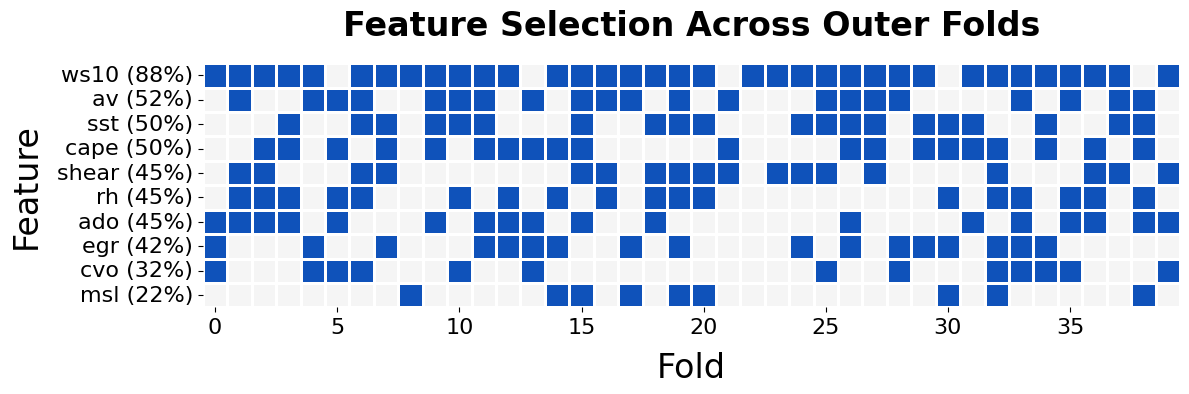

In [10]:
# Create figure with larger size to accommodate labels
fig, ax = plt.subplots(figsize=(12, 10))

# Create your dataframe
df = pd.DataFrame(sorted_arr)
df.index = feature_heatmap_labels

sns.heatmap(df, 
    cmap=['#f5f5f5', '#0f52ba'],
    cbar=False,
    linewidths=1,
    linecolor='white',
    square=True,
    ax=ax)
plt.title("Feature Selection Across Outer Folds", 
    pad=20,
    fontsize=24,
    fontweight='bold',
    fontfamily='sans-serif')
plt.xlabel("Fold", 
    fontsize=24,
    fontweight='medium',
    labelpad=10)
plt.ylabel("Feature", 
    fontsize=24,
    fontweight='medium',
    labelpad=10)

plt.yticks(rotation=0, fontsize=16)
xticks = ax.get_xticks()
xtick_labels = [item.get_text() for item in ax.get_xticklabels()]

# Now slice the ticks and labels so that only every 5th label is shown.
ax.set_xticks(xticks[::5])
# Sometimes, the tick labels might be empty strings if not explicitly set,
# so you can force them to be the corresponding tick values:
ax.set_xticklabels([str(int(tick)) for tick in xticks[::5]], fontsize=16)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

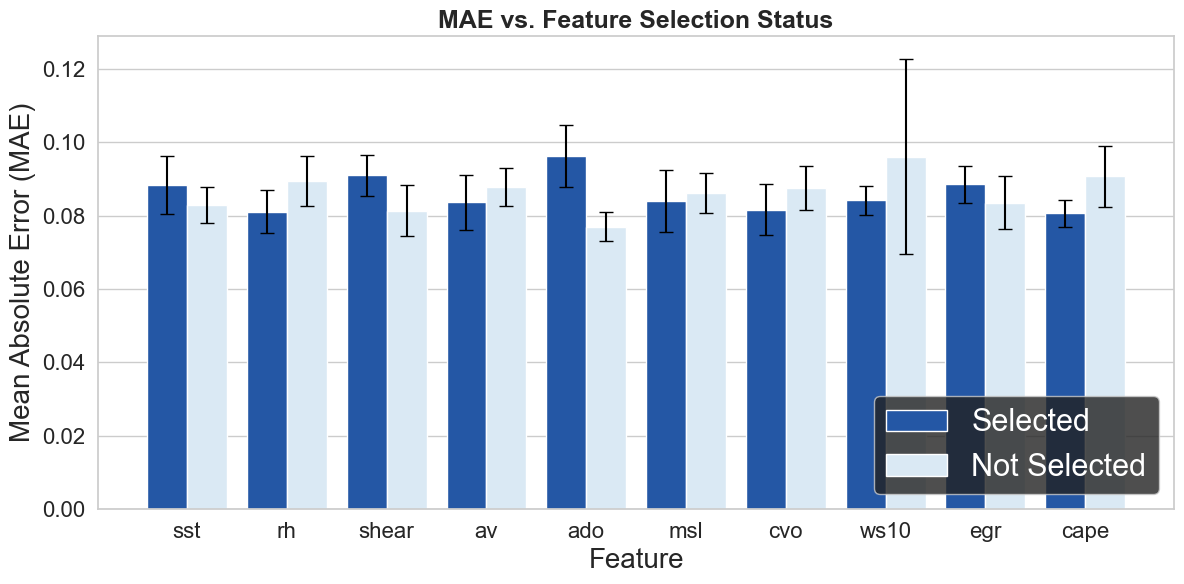

In [11]:
# -------------------------------------------------------------------
# Process the data: For each feature, collect the MAE values when selected vs. not selected.
# -------------------------------------------------------------------
features = feature_names
# Initialize a dictionary to hold the MAE values per feature for each group.
perf_data = {feature: {'Selected': [], 'Not Selected': []} for feature in features}

# For each fold, check for each feature whether it was selected, and record the corresponding MAE.
for hp_dict, mae in zip(outer_best_hps, outer_fold_mae):
    for i, feature in enumerate(features):
        key = f'use_feature_{i}'
        if hp_dict.get(key, True):  # if the key is missing, we assume it was selected
            perf_data[feature]['Selected'].append(mae)
        else:
            perf_data[feature]['Not Selected'].append(mae)

# For each feature, compute the mean MAE and standard error for each group.
results = []
for feature in features:
    for status in ['Selected', 'Not Selected']:
        mae_values = perf_data[feature][status]
        if len(mae_values) > 0:
            mean_mae = np.mean(mae_values)
            # Standard error: std / sqrt(n)
            stderr = np.std(mae_values, ddof=1) / np.sqrt(len(mae_values))
        else:
            mean_mae = np.nan
            stderr = np.nan
        results.append({
            'Feature': feature,
            'Status': status,
            'Mean MAE': mean_mae,
            'StdErr': stderr,
            'Count': len(mae_values)
        })

# Convert results to a DataFrame.
df_results = pd.DataFrame(results)

# -------------------------------------------------------------------
# Plot: Grouped bar plot comparing the average MAE for "Selected" vs. "Not Selected" for each feature.
# -------------------------------------------------------------------
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Create a grouped bar plot using Seaborn's barplot.
ax = sns.barplot(data=df_results, x='Feature', y='Mean MAE', hue='Status',
                 palette={'Selected': "#0f52ba", 'Not Selected': "#D6EAF8"},
                 errorbar=None)

# Add error bars manually.
for i, feature in enumerate(features):
    for j, status in enumerate(['Selected', 'Not Selected']):
        # Filter the row corresponding to this feature and status.
        row = df_results[(df_results['Feature'] == feature) & (df_results['Status'] == status)]
        if not row.empty and not np.isnan(row['StdErr'].values[0]):
            # Seaborn places the bars at positions that we can retrieve.
            # In a grouped bar plot, each group is at position i, with a slight offset for each hue.
            # A quick approach is to retrieve the x-coordinate of the bars.
            x_coords = [patch.get_x() + patch.get_width() / 2. for patch in ax.patches if np.isclose(patch.get_x() + patch.get_width() / 2., i, atol=0.4)]
            # Alternatively, if the order is fixed, we can calculate approximate offsets.
            # For two groups, use an offset of ±0.2.
            offset = -0.2 if status == 'Selected' else 0.2
            # Calculate the x-coordinate for the current group.
            x = i + offset
            y = row['Mean MAE'].values[0]
            err = row['StdErr'].values[0]
            plt.errorbar(x=x, y=y, yerr=err, fmt='none', c='black', capsize=5)

# Beautify the plot.
plt.title("MAE vs. Feature Selection Status", fontsize=18, weight='bold')
plt.xlabel("Feature", fontsize=20)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=22, loc='lower right', facecolor='#222222', labelcolor='white')
plt.tight_layout()

# Optionally, save the figure in high resolution.
plt.savefig("mae_vs_feature_selection.png", dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# Create a 10x10 matrix where entry (i,j) represents how often 
# features i and j are selected together
cooccurrence = np.zeros((10, 10))
for fold_hp in outer_best_hps:
    selected = [i for i in range(10) if fold_hp[f'use_feature_{i}']]
    for i in selected:
        for j in selected:
            cooccurrence[i,j] += 1

# Normalize by the number of times each feature appears
# This gives you P(feature j is selected | feature i is selected)
normalized_cooccurrence = cooccurrence / (cooccurrence.diagonal()[:, None] + 1e-10)

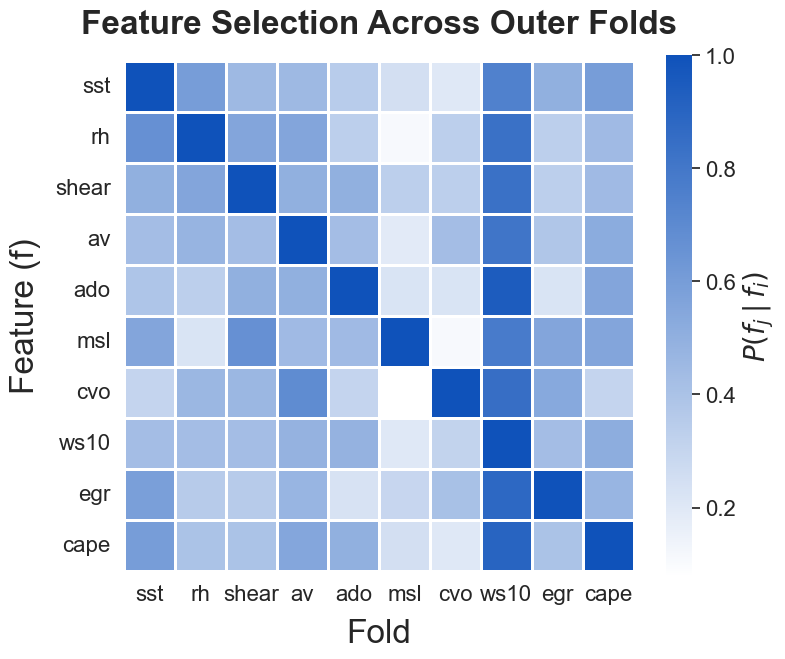

In [13]:
# Create a custom colormap
# The list is ordered from the minimum value (0) to the maximum value (1)
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#ffffff", "#0f52ba"])

# Create figure with larger size to accommodate labels
fig, ax = plt.subplots(figsize=(8, 8))

# Create your dataframe
hm = sns.heatmap(normalized_cooccurrence, 
    cmap=cmap,
    cbar=True,
    cbar_kws={'shrink': 0.7},
    linewidths=1,
    linecolor='white',
    square=True,
    ax=ax,
    xticklabels=feature_names,
    yticklabels=feature_names)
# Increase the tick label size on the colorbar
cbar = hm.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)  # Set the tick label size to 20 (adjust as needed)
cbar.set_label(r'$P(f_{j}\:|\:f_{i})$', size=20)  # Adjust size as needed
plt.title("Feature Selection Across Outer Folds", 
    pad=20,
    fontsize=24,
    fontweight='bold',
    fontfamily='sans-serif')
plt.xlabel("Fold", 
    fontsize=24,
    fontweight='medium',
    labelpad=10)
plt.ylabel("Feature (f)", 
    fontsize=24,
    fontweight='medium',
    labelpad=10)

plt.yticks(rotation=0, fontsize=16)
plt.xticks(rotation=0, fontsize=16)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

In [14]:
def get_performance_for_feature_combo(results, feature_i, feature_j):
    maes_with_both = []
    maes_with_i_only = []
    maes_with_j_only = []
    maes_with_neither = []
    
    for fold in range(len(results)):
        hp = outer_best_hps[fold]
        mae = outer_fold_mae[fold]
        has_i = hp[f'use_feature_{feature_i}']
        has_j = hp[f'use_feature_{feature_j}']
        
        if has_i and has_j:
            maes_with_both.append(mae)
        elif has_i:
            maes_with_i_only.append(mae)
        elif has_j:
            maes_with_j_only.append(mae)
        else:
            maes_with_neither.append(mae)
            
    return {
        'both': np.mean(maes_with_both) if maes_with_both else None,
        'i_only': np.mean(maes_with_i_only) if maes_with_i_only else None,
        'j_only': np.mean(maes_with_j_only) if maes_with_j_only else None,
        'neither': np.mean(maes_with_neither) if maes_with_neither else None
    }

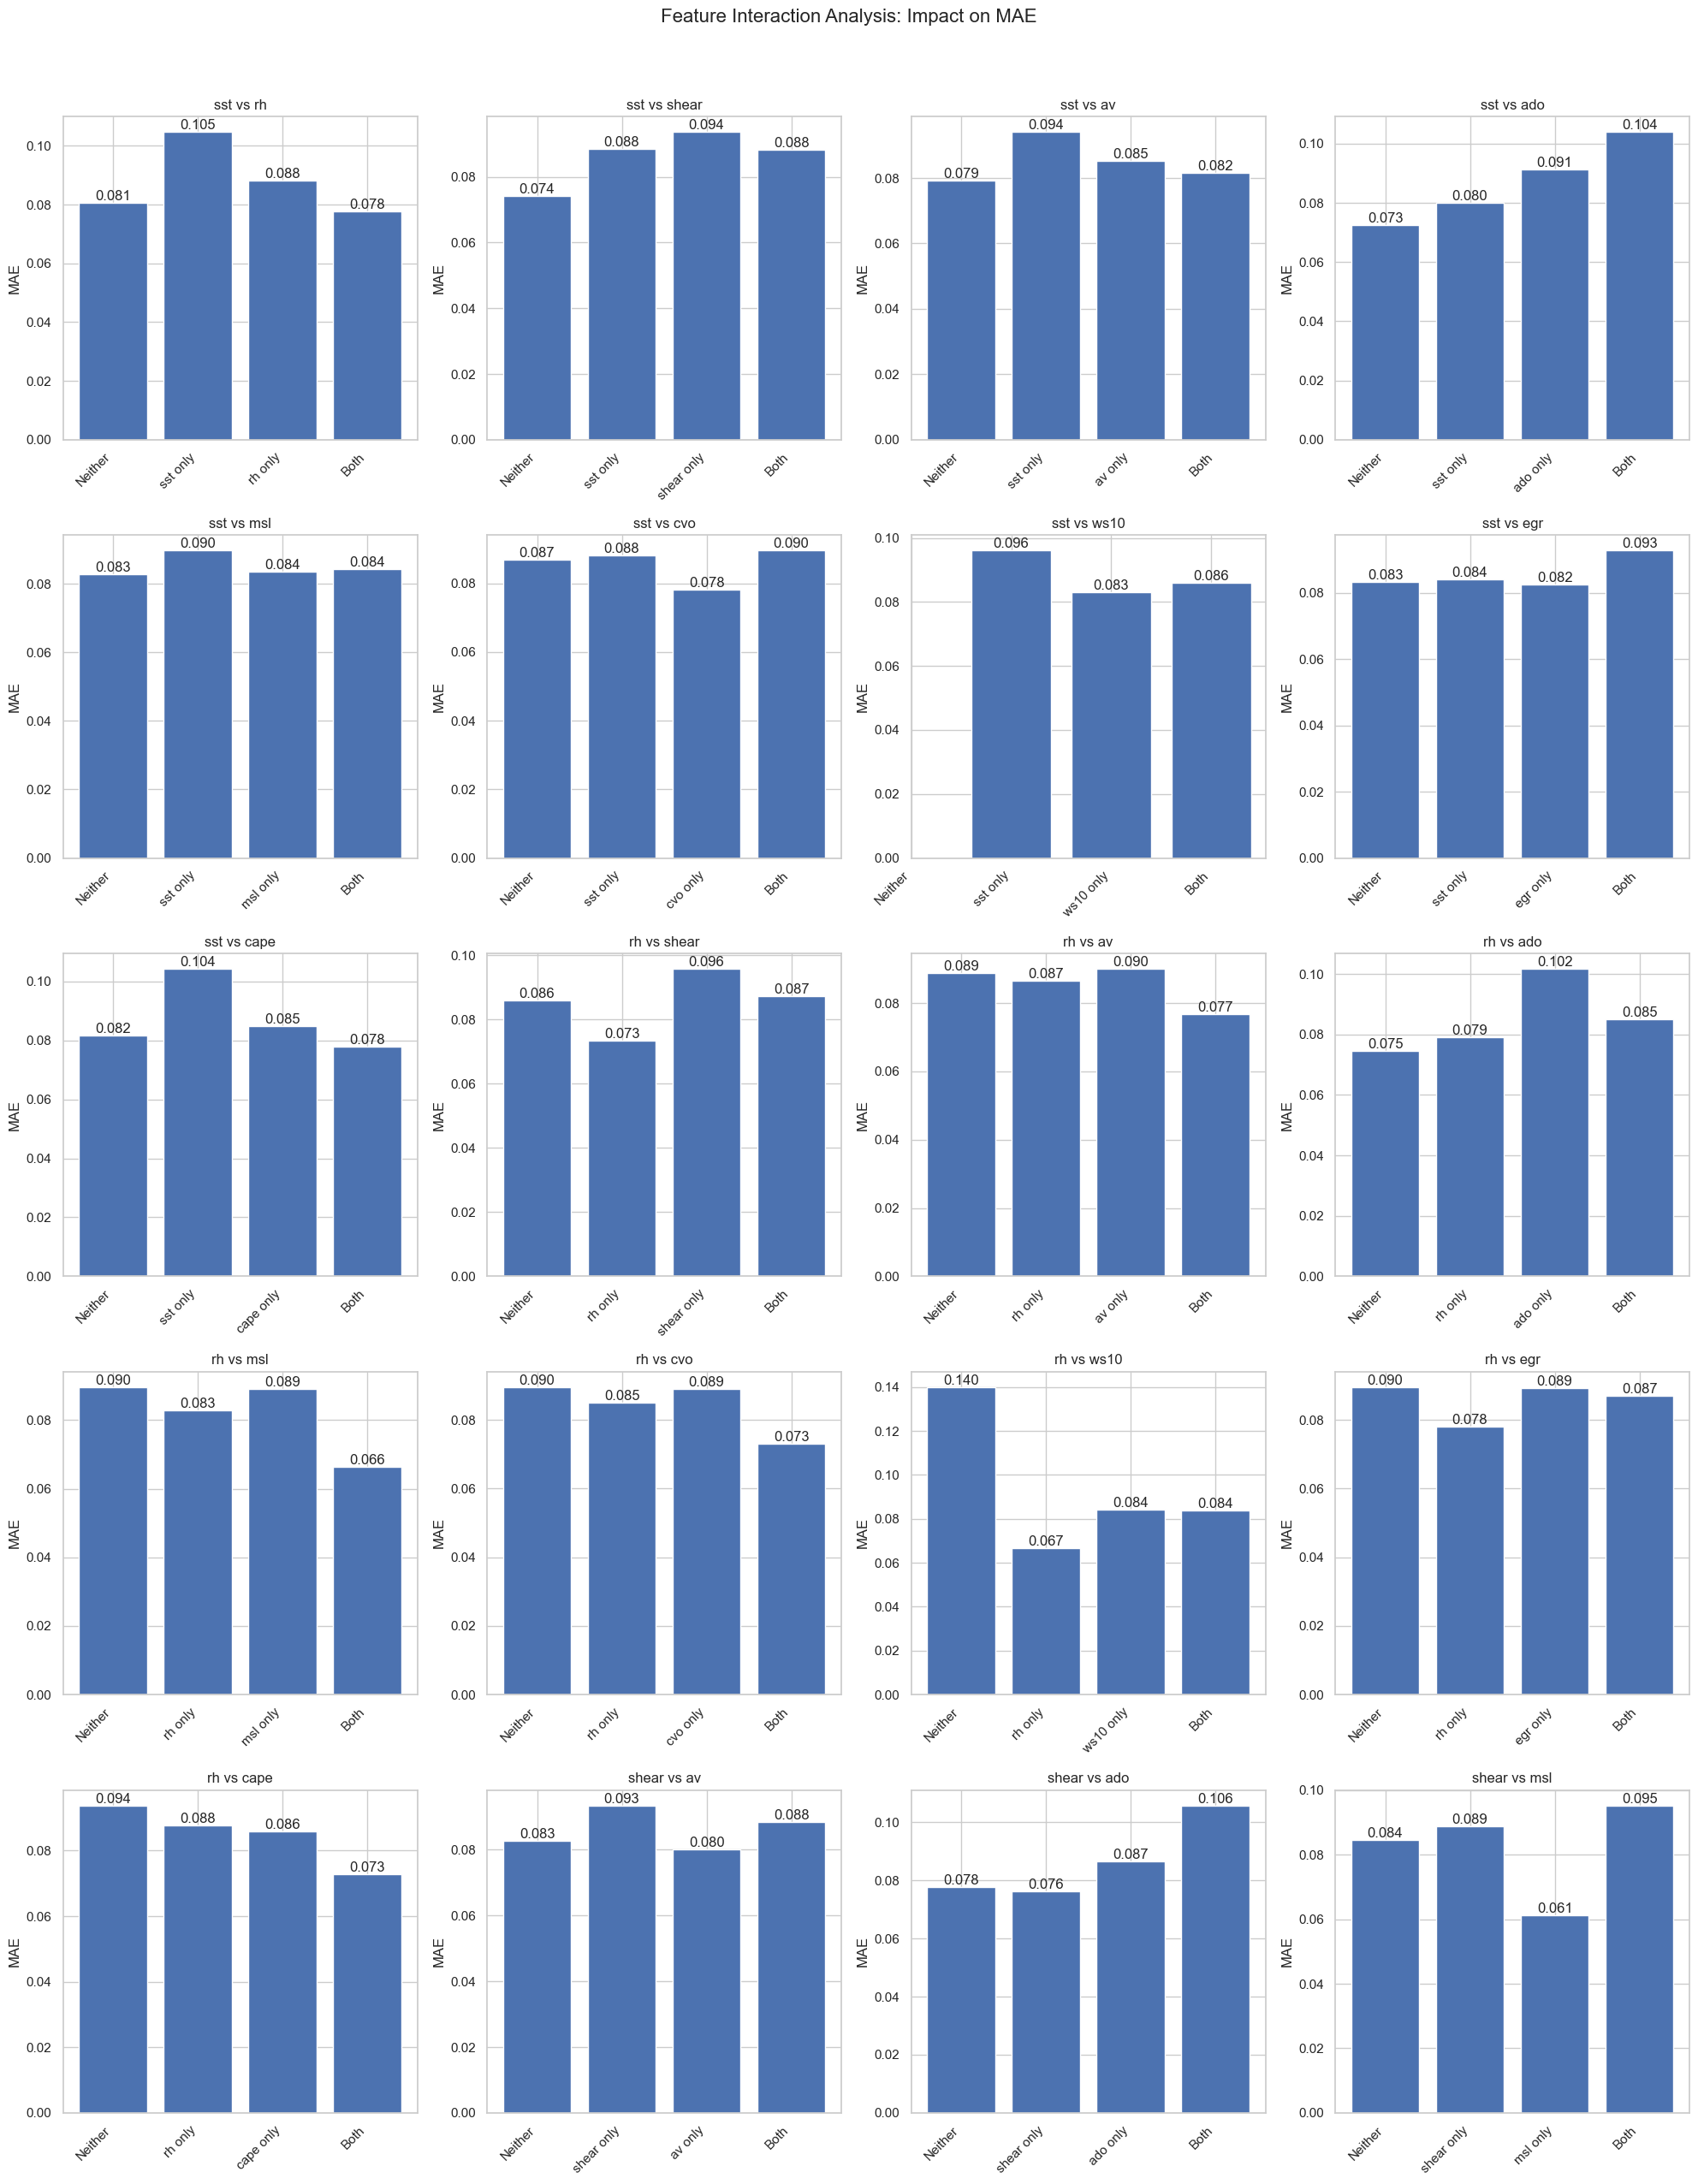


Most complementary features (pairs where using both improves performance):
av + cvo: 0.018 MAE improvement
rh + msl: 0.017 MAE improvement
rh + cape: 0.013 MAE improvement
rh + cvo: 0.012 MAE improvement
av + cape: 0.011 MAE improvement


In [15]:
# First, let's analyze all pairs of features
n_features = 10
interaction_results = {}

for i in range(n_features):
    for j in range(i+1, n_features):  # Only do upper triangle to avoid redundancy
        results = get_performance_for_feature_combo(outer_fold_mae, i, j)
        interaction_results[(i,j)] = results

# Create a visualization
fig, axs = plt.subplots(5, 4, figsize=(20, 25))  # Adjust size as needed
axs = axs.ravel()

for idx, ((i, j), results) in enumerate(interaction_results.items()):
    if idx >= len(axs):  # Skip if we run out of subplot space
        break
        
    # Prepare data for plotting
    labels = ['Neither', f'{feature_names[i]} only', 
              f'{feature_names[j]} only', 'Both']
    values = [results['neither'], results['i_only'], 
              results['j_only'], results['both']]
    
    # Replace None with NaN for plotting
    values = [v if v is not None else np.nan for v in values]
    
    # Create bar plot
    bars = axs[idx].bar(range(len(values)), values)
    axs[idx].set_xticks(range(len(labels)))
    axs[idx].set_xticklabels(labels, rotation=45, ha='right')
    axs[idx].set_title(f'{feature_names[i]} vs {feature_names[j]}')
    axs[idx].set_ylabel('MAE')
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):
            axs[idx].text(bar.get_x() + bar.get_width()/2., height,
                         f'{height:.3f}',
                         ha='center', va='bottom')

# Remove empty subplots if any
for idx in range(len(interaction_results), len(axs)):
    fig.delaxes(axs[idx])

plt.suptitle('Feature Interaction Analysis: Impact on MAE', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Print a summary of the most interesting interactions
print("\nMost complementary features (pairs where using both improves performance):")
complementary_pairs = []
for (i,j), results in interaction_results.items():
    if all(v is not None for v in results.values()):  # Only consider complete results
        improvement = min(results['i_only'], results['j_only']) - results['both']
        if improvement > 0:
            complementary_pairs.append(((i,j), improvement))

for (i,j), improvement in sorted(complementary_pairs, 
                               key=lambda x: x[1], reverse=True)[:5]:
    print(f"{feature_names[i]} + {feature_names[j]}: {improvement:.3f} MAE improvement")

In [16]:
x = np.load('data/stacked.npy')
x, train_mins, train_maxs = normalize_data(x)
ace_orig = np.load('data/ace.npy')

predictions = []

for outer_fold in range(years_total):
    start = outer_fold * 12
    end = start + 12
    test_idx = np.arange(start, end)
    
    # Get the best hyperparameters for this fold
    best_hp = outer_best_hps[outer_fold]
    
    # Rebuild the model with the same architecture
    best_model = build_model(best_hp, is_dict=True)
    
    # Load just the weights
    best_model.load_weights(f'saved_weights/model_fold_{outer_fold}.hdf5')
    
    predictions_ = best_model.predict(x[test_idx], verbose=0)
    predictions.append(predictions_.flatten())
    
predictions = np.array(predictions)
predictions[predictions<0] = 0

In [17]:
ace_orig[:7].shape

(7, 12)

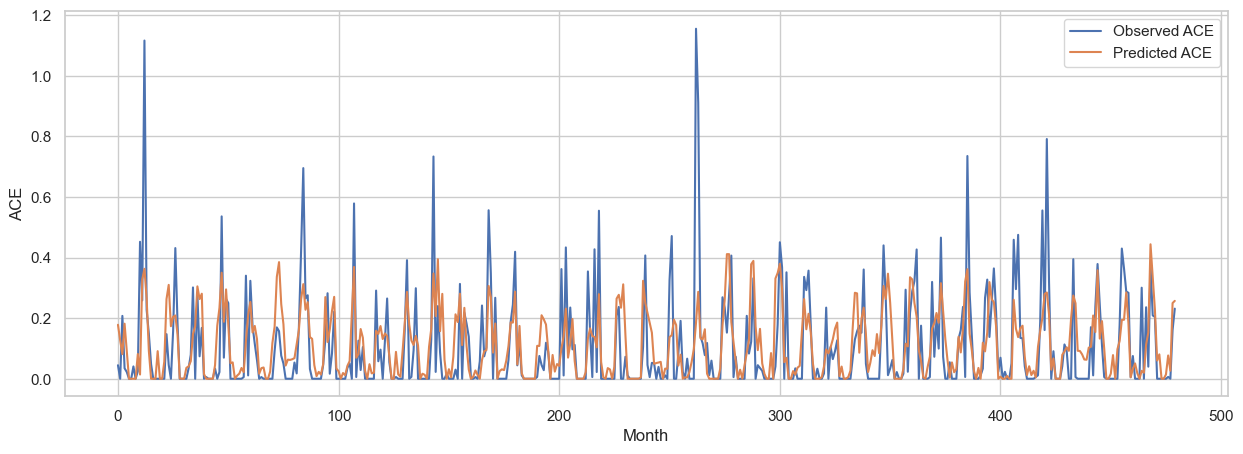

In [18]:
predictions_cheat = predictions.copy()
predictions_cheat[predictions<0.1] = 0

# Now you can plot
plt.figure(figsize=(15, 5))
plt.plot(np.arange(num_samples), ace_orig.flatten(), label='Observed ACE')
plt.plot(np.arange(num_samples), predictions.flatten(), label='Predicted ACE')
plt.legend()
plt.xlabel('Month')
plt.ylabel('ACE')
plt.show()

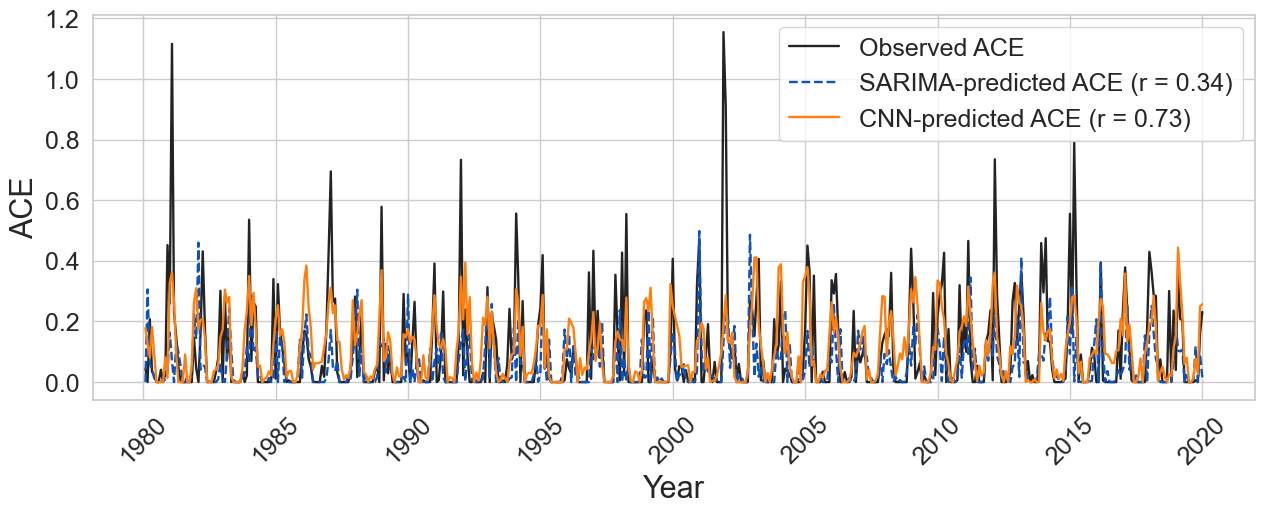

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Generate the datetime index from January 1980 to December 2019
date_range = pd.date_range(start="1980-01", periods=480, freq="M")

plt.figure(figsize=(15, 5))
plt.plot(date_range, ace_orig.flatten(), label='Observed ACE', linewidth=1.7, color='#232323')
plt.plot(date_range, predictions_sarima, label='SARIMA-predicted ACE (r = 0.34)', linewidth=1.7, linestyle='--', color='#0f52ba')
plt.plot(date_range, predictions.flatten(), label='CNN-predicted ACE (r = 0.73)', linewidth=1.7, color='#ff7f0e')

# Formatting x-axis
plt.xlabel('Year', fontsize=22)
plt.ylabel('ACE', fontsize=22)
plt.legend(fontsize=18)

# Set major x-axis locator to yearly intervals
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))  # Show a label every 5 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display only the year

plt.xticks(rotation=45, fontsize=18)  # Rotate labels for better readability
plt.yticks(fontsize=18)
plt.show()


In [20]:
from sklearn.preprocessing import QuantileTransformer

def quantile_mse (complete_dataset, actual, forecast):
    #assign to every value its quantile value
    quantile_transformer = QuantileTransformer(n_quantiles=480, output_distribution='uniform')
    #Fit and transform the data
    q = complete_dataset.flatten()
    transformed_data = quantile_transformer.fit_transform(q.reshape(-1, 1))
    transformed_data = transformed_data.reshape(-1)
    #Compute the weighted squared error
    wse = transformed_data*((actual-forecast)**2)
    return np.mean(wse)

In [21]:
mae = err_func(1)
mse = err_func(2)

mae_sarima = mae(ace_orig.flatten(), predictions_sarima.flatten())
mae_cnn = mae(ace_orig.flatten(), predictions.flatten())

mse_sarima = mse(ace_orig.flatten(), predictions_sarima.flatten())
mse_cnn = mse(ace_orig.flatten(), predictions.flatten())

wmse_sarima = quantile_mse (ace_orig.flatten(), ace_orig.flatten(), predictions_sarima.flatten())
wmse_cnn = quantile_mse (ace_orig.flatten(), ace_orig.flatten(), predictions.flatten())

r_sarima, _ = pearsonr(ace_orig.flatten(), predictions_sarima.flatten())
r_cnn, _ = pearsonr(ace_orig.flatten(), predictions.flatten())

In [22]:
print(f'MAE SARIMA: {mae_sarima.numpy():.2f} -- MAE CNN: {mae_cnn.numpy():.2f}')
print(f'MSE SARIMA: {mse_sarima.numpy():.2f} -- MSE CNN: {mse_cnn.numpy():.2f}')
print(f'r SARIMA: {r_sarima:.2f}   -- r CNN: {r_cnn:.2f}')

MAE SARIMA: 0.09 -- MAE CNN: 0.08
MSE SARIMA: 0.03 -- MSE CNN: 0.02
r SARIMA: 0.34   -- r CNN: 0.62


### Hyperparameters results

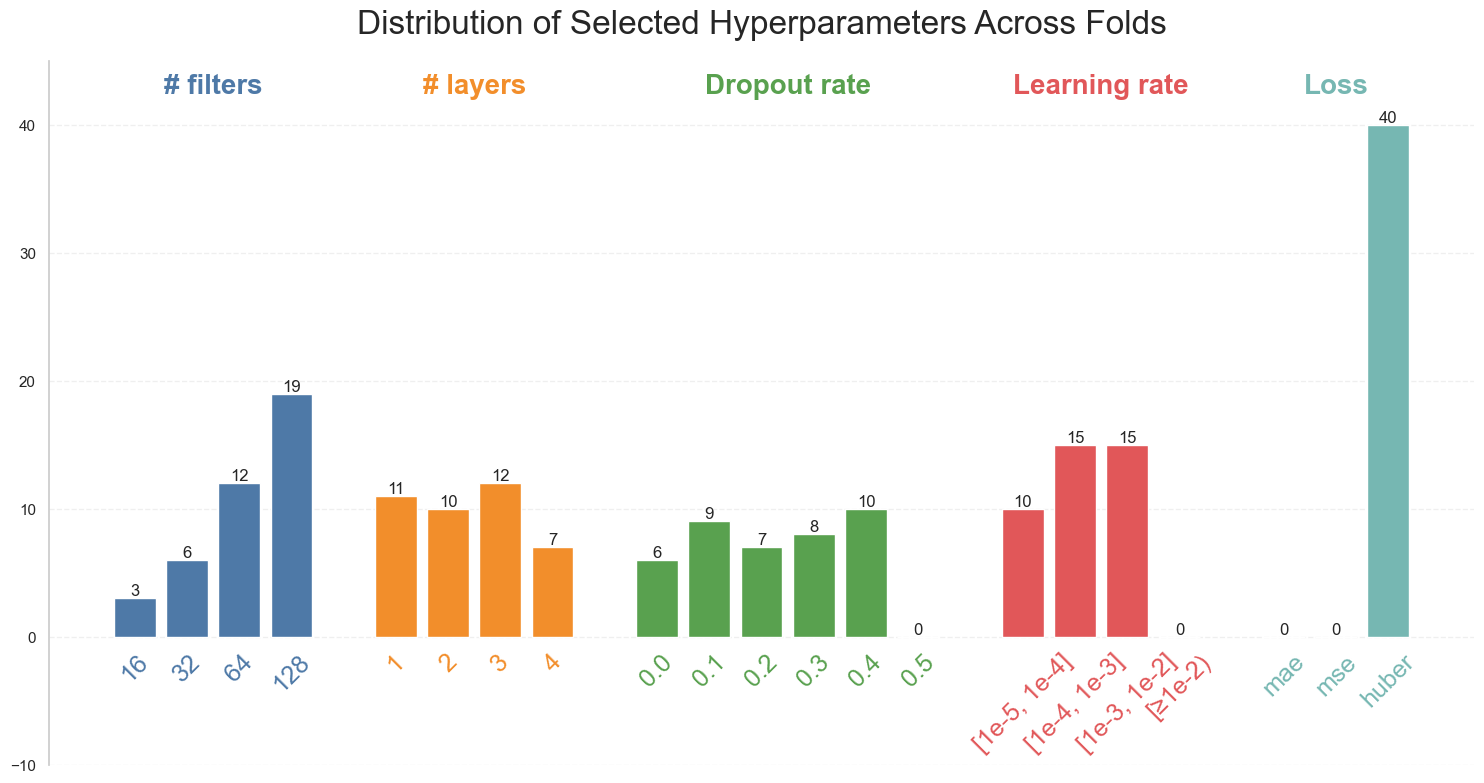

In [23]:
def plot_hyperparameter_distribution(outer_best_hps):
    """
    Create a bar plot showing the distribution of hyperparameter choices across folds,
    with improved label placement and readability.
    """
    # Process hyperparameters into counts (same as before)
    filters_count = {16: 0, 32: 0, 64: 0, 128: 0}
    layers_count = {1: 0, 2: 0, 3: 0, 4: 0}
    dropout_count = {0.0: 0, 0.1: 0, 0.2: 0, 0.3: 0, 0.4: 0, 0.5: 0}
    lr_bins = {
        '[1e-5, 1e-4]': 0,
        '[1e-4, 1e-3]': 0,
        '[1e-3, 1e-2]': 0,
        '[≥1e-2)': 0
    }
    loss_count = {'mae': 0, 'mse': 0, 'huber': 0}
    
    # Bin learning rates
    def bin_learning_rate(lr):
        if lr < 1e-4:
            return '[1e-5, 1e-4]'
        elif lr < 1e-3:
            return '[1e-4, 1e-3]'
        elif lr < 1e-2:
            return '[1e-3, 1e-2]'
        else:
            return '[1e-2)'
    
    # Count occurrences
    for hp in outer_best_hps:
        filters_count[hp['filters']] += 1
        layers_count[hp['num_conv_layers']] += 1
        dropout_count[round(hp['dropout_rate'], 1)] += 1
        lr_bins[bin_learning_rate(hp['learning_rate'])] += 1
        loss_count[hp['loss_func']] += 1
    
    # Create figure with larger height to accommodate labels
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Define colors for each group
    colors = ['#4e79a7', '#f28e2b', '#59a14f', '#e15759', '#76b7b2']
    
    # Define bar width and spacing
    bar_width = 0.8
    group_spacing = 1  # Increased spacing between groups
    
    # Calculate positions for each group
    def get_group_positions(values, start_pos):
        return np.arange(len(values)) + start_pos
    
    # Plot each group
    current_pos = 0
    
    # Filters section
    filter_positions = get_group_positions(filters_count, current_pos)
    ax.bar(filter_positions, filters_count.values(), bar_width, color=colors[0])
    current_pos += len(filters_count) + group_spacing
    
    # Layers section
    layer_positions = get_group_positions(layers_count, current_pos)
    ax.bar(layer_positions, layers_count.values(), bar_width, color=colors[1])
    current_pos += len(layers_count) + group_spacing
    
    # Dropout section
    dropout_positions = get_group_positions(dropout_count, current_pos)
    ax.bar(dropout_positions, dropout_count.values(), bar_width, color=colors[2])
    current_pos += len(dropout_count) + group_spacing
    
    # Learning rate section
    lr_positions = get_group_positions(lr_bins, current_pos)
    ax.bar(lr_positions, lr_bins.values(), bar_width, color=colors[3])
    current_pos += len(lr_bins) + group_spacing
    
    # Loss function section
    loss_positions = get_group_positions(loss_count, current_pos)
    ax.bar(loss_positions, loss_count.values(), bar_width, color=colors[4])
    
    # Function to add value labels and category labels
    def add_labels(positions, values, names, color):
        for pos, value, name in zip(positions, values, names):
            # Add value on top of bar
            ax.text(pos, value, str(value), ha='center', va='bottom')
            # Add category label below bar
            ax.text(pos, -1, str(name), ha='center', va='top', rotation=45,
                   color=color, fontsize=18)
    
    # Add labels for each group
    add_labels(filter_positions, filters_count.values(), filters_count.keys(), colors[0])
    add_labels(layer_positions, layers_count.values(), layers_count.keys(), colors[1])
    add_labels(dropout_positions, dropout_count.values(), dropout_count.keys(), colors[2])
    add_labels(lr_positions, lr_bins.values(), lr_bins.keys(), colors[3])
    add_labels(loss_positions, loss_count.values(), loss_count.keys(), colors[4])
    
    # Add group titles
    group_positions = [
        np.mean(filter_positions),
        np.mean(layer_positions),
        np.mean(dropout_positions),
        np.mean(lr_positions),
        np.mean(loss_positions)
    ]
    
    group_labels = ['# filters', '# layers', 'Dropout rate', 'Learning rate', 'Loss']
    
    # Add group labels with matching colors
    for pos, label, color in zip(group_positions, group_labels, colors):
        ax.text(pos, ax.get_ylim()[1], label, ha='center', va='bottom', 
                color=color, fontweight='bold', fontsize=20)
    
    # Customize the plot
    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_ylim(-10, 45)  # Adjust y-axis limits to accommodate labels
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)
    ax.set_title('Distribution of Selected Hyperparameters Across Folds', 
                pad=20, fontsize=24)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.tight_layout()
    return fig, ax

fig, ax = plot_hyperparameter_distribution(outer_best_hps)
plt.show()

## Saliency maps

In [24]:
# Average the saliency maps over folds (only for folds where the feature was used)
final_saliency_maps = {}
for i in range(10):
    if saliency_counts[i] > 0:
        final_saliency_maps[i] = saliency_maps[i] / saliency_counts[i]
    else:
        print(f"\nFeature {i} was never selected in any fold.")

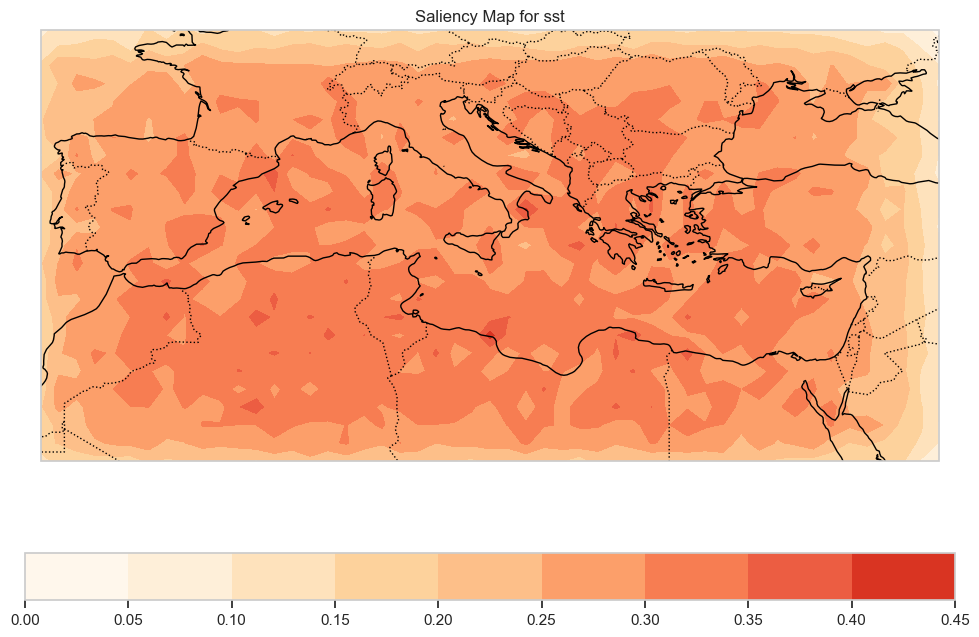

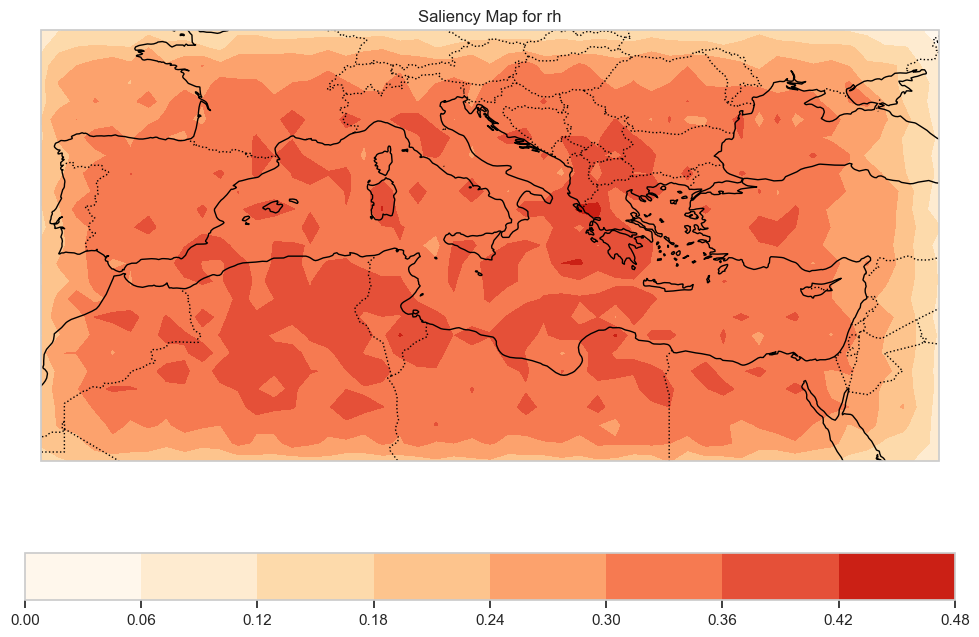

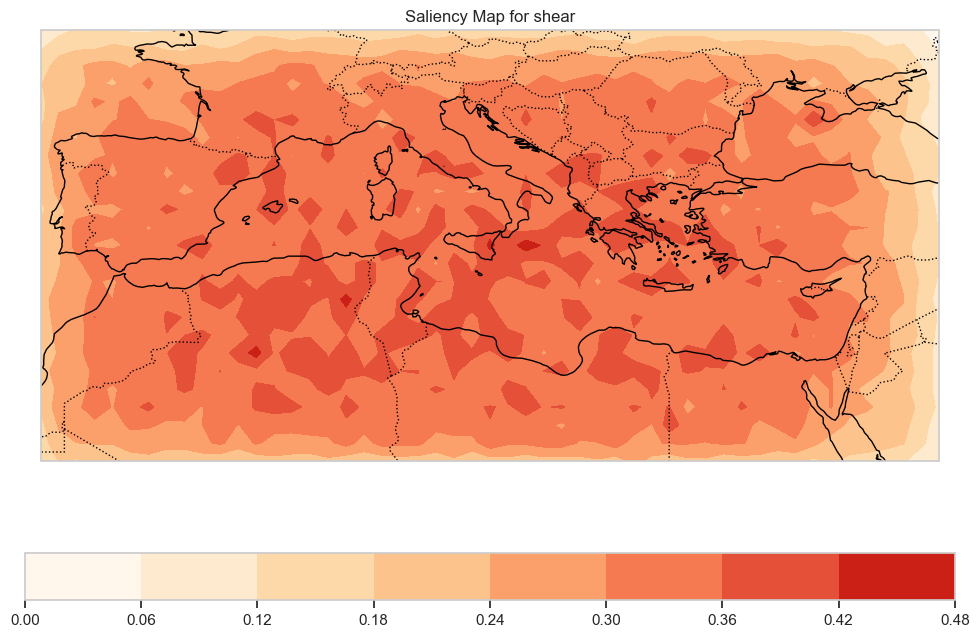

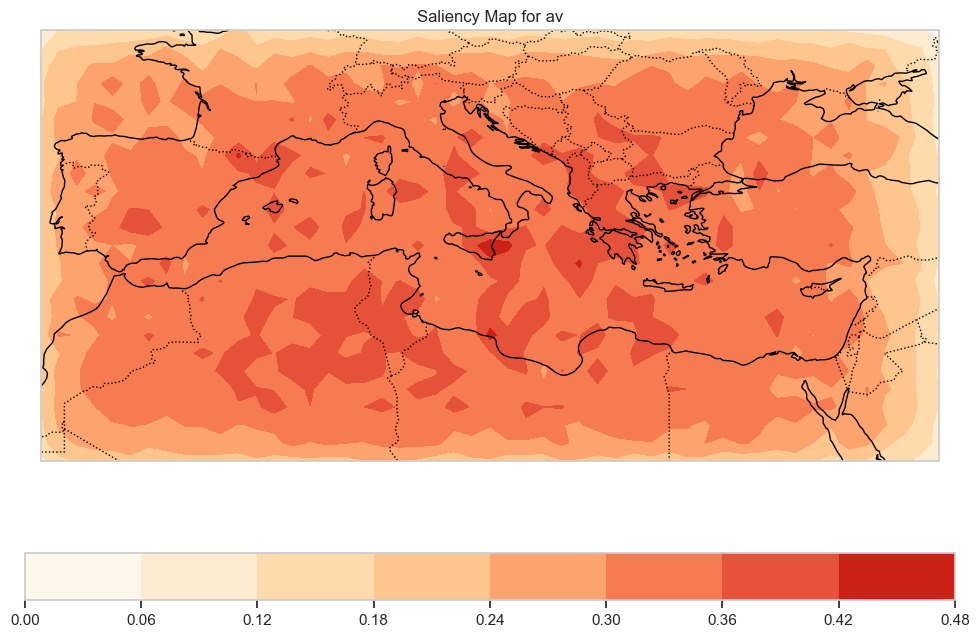

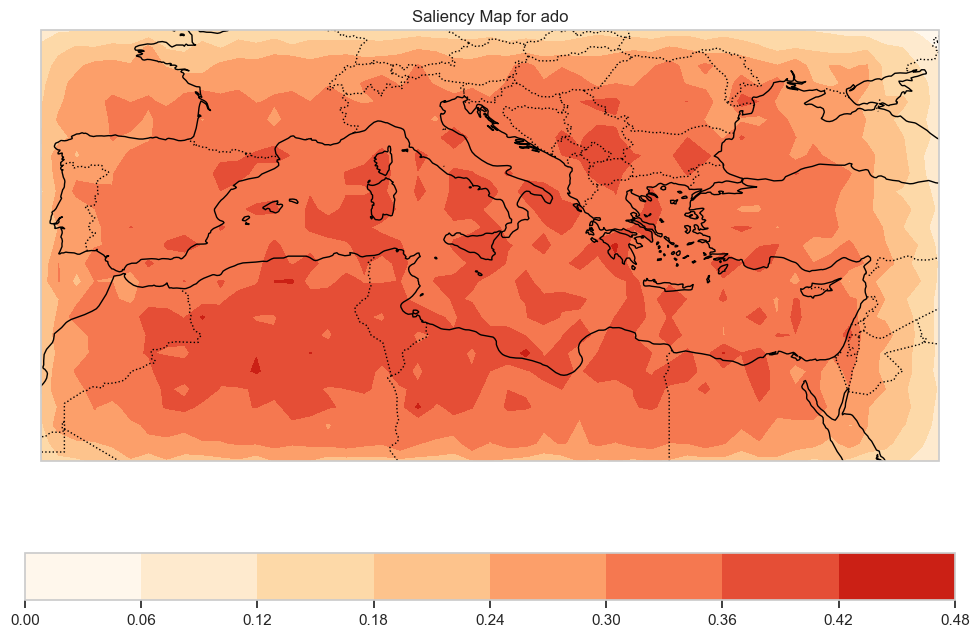

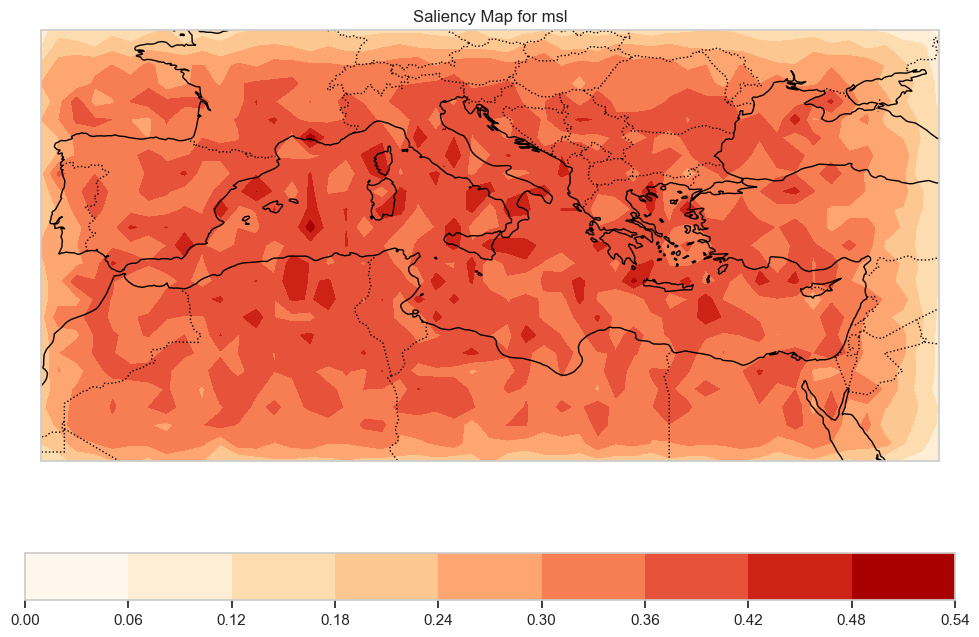

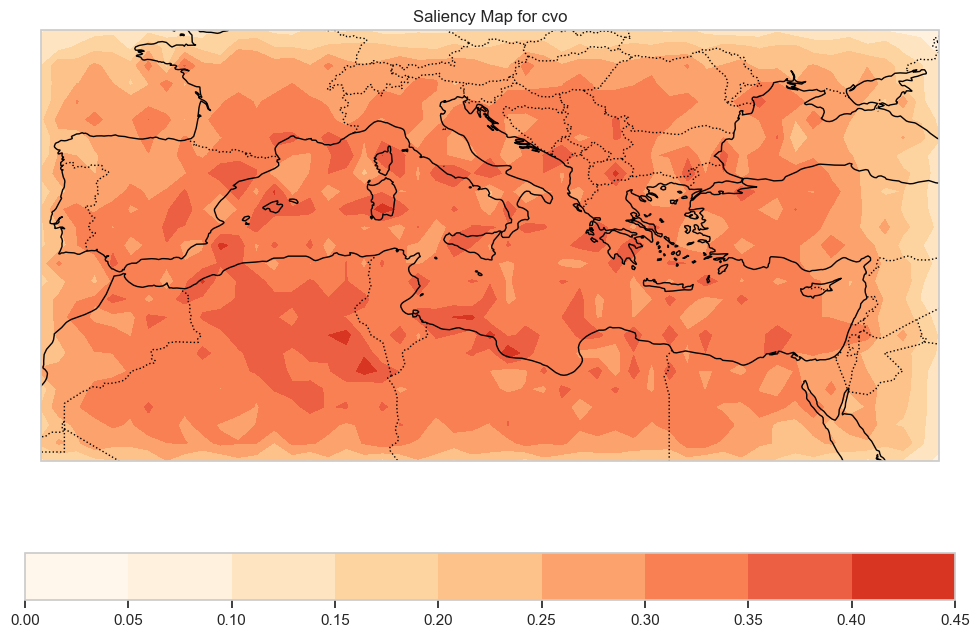

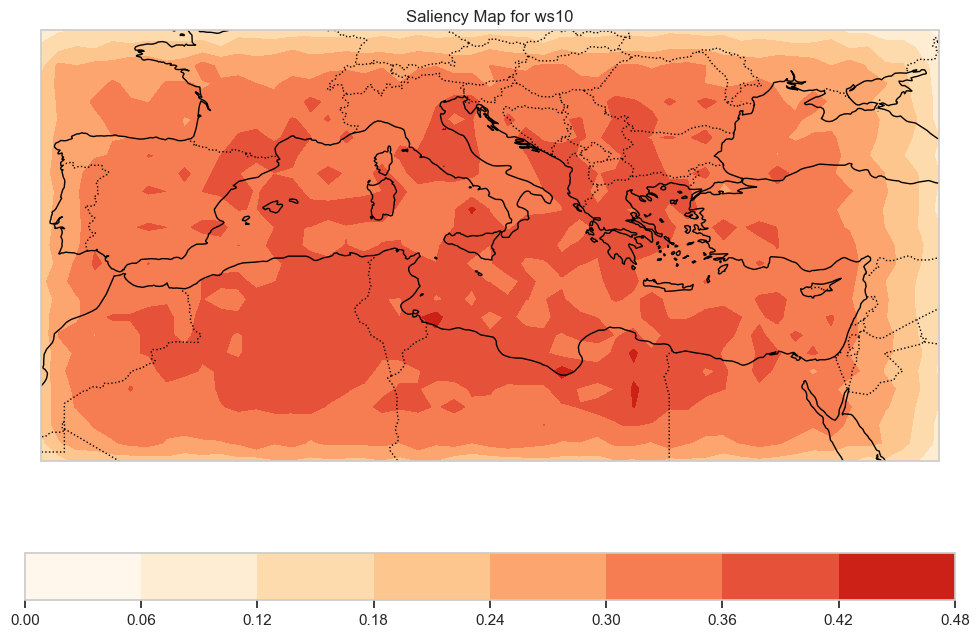

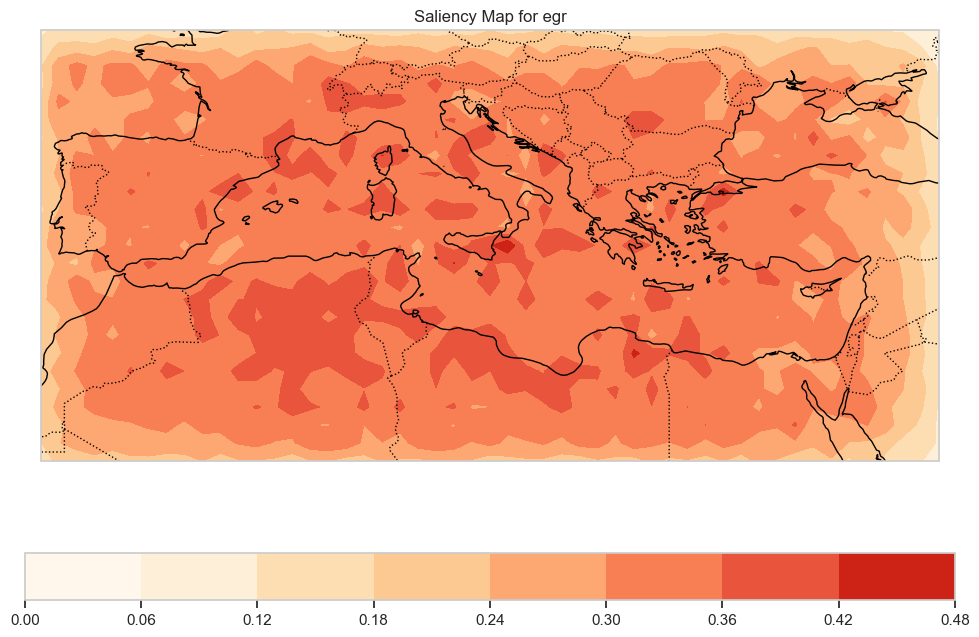

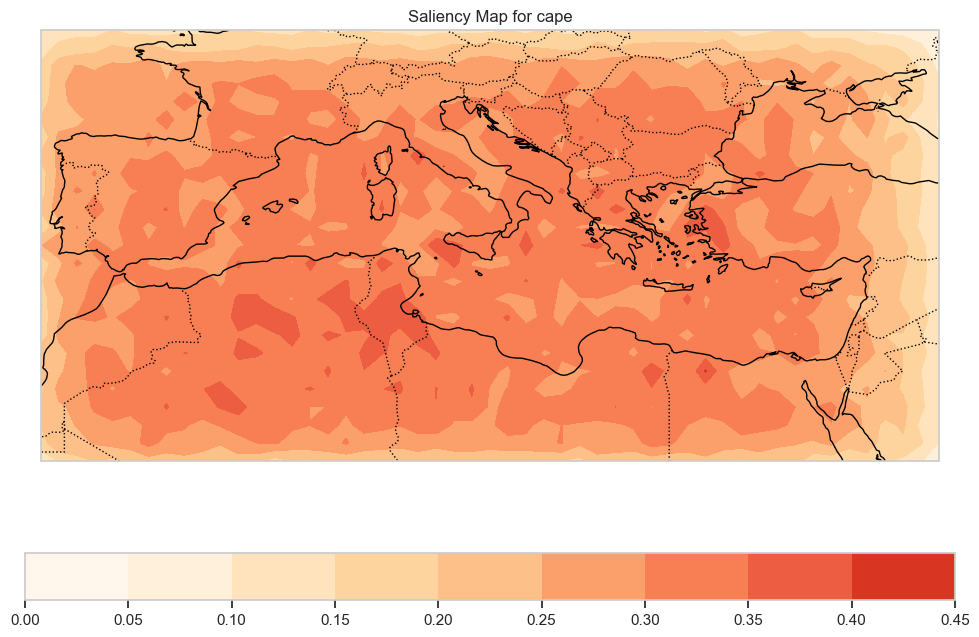

In [25]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

with xr.open_dataset(f"data/des_inputs/egr_d.nc") as ds:
    lats = ds['lat'].values
    lons = ds['lon'].values

vmin = np.nanmin(final_saliency_maps)
vmax = np.nanmax(final_saliency_maps)

for feature_idx, sal_map in final_saliency_maps.items():
    vmin = np.nanmin(sal_map)
    #vmax = np.nanmax(sal_map)
    vmax = 0.56
    plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    cs = ax.contourf(lons, lats, sal_map, transform=ccrs.PlateCarree(),vmin = vmin, vmax=0.56 ,cmap='OrRd') 
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    plt.colorbar(cs, ax=ax, extend='both', orientation = 'horizontal')
    ax.set_title(f'Saliency Map for {feature_names[feature_idx]}')
    plt.show()

In [26]:
import numpy as np
from scipy.stats import pearsonr
from scipy import stats

def compute_ensemble_predictions(x, years_total, outer_best_hps, build_model):
    """
    Compute ensemble predictions and confidence intervals using all models
    except the one that was trained on the data being predicted.
    
    Returns:
        - original_predictions: predictions from each model on its test set
        - ensemble_means: mean predictions from other models
        - ensemble_stds: standard deviations of predictions
        - ci_lower, ci_upper: confidence interval bounds
    """
    num_samples = x.shape[0]
    original_predictions = np.zeros(num_samples)
    ensemble_predictions = np.zeros((num_samples, years_total-1))
    
    # First, get the original predictions (from each model on its test set)
    for outer_fold in range(years_total):
        start = outer_fold * 12
        end = start + 12
        test_idx = np.arange(start, end)
        
        # Get the best hyperparameters for this fold
        best_hp = outer_best_hps[outer_fold]
        
        # Rebuild the model with the same architecture
        best_model = build_model(best_hp, is_dict=True)
        
        # Load the weights
        best_model.load_weights(f'saved_weights/model_fold_{outer_fold}.hdf5')
        
        # Get predictions for the test set
        pred = best_model.predict(x[test_idx], verbose=0).flatten()
        original_predictions[test_idx] = pred
        
        # Now get predictions from all OTHER models for this same period
        model_idx = 0
        for other_fold in range(years_total):
            if other_fold != outer_fold:
                other_hp = outer_best_hps[other_fold]
                other_model = build_model(other_hp, is_dict=True)
                other_model.load_weights(f'saved_weights/model_fold_{other_fold}.hdf5')
                
                ensemble_predictions[test_idx, model_idx] = other_model.predict(
                    x[test_idx], verbose=0
                ).flatten()
                model_idx += 1
    
    # Compute statistics
    ensemble_means = np.mean(ensemble_predictions, axis=1)
    ensemble_stds = np.std(ensemble_predictions, axis=1)
    
    # Compute 95% confidence intervals
    ci_lower = ensemble_means - 1.96 * ensemble_stds
    ci_upper = ensemble_means + 1.96 * ensemble_stds
    
    # Ensure no negative values
    original_predictions = np.maximum(original_predictions, 0)
    ci_lower = np.maximum(ci_lower, 0)
    ci_upper = np.maximum(ci_upper, 0)
    
    return original_predictions, ensemble_means, ensemble_stds, ci_lower, ci_upper

def analyze_uncertainty_patterns(original_predictions, ensemble_stds, ace_orig, years_total):
    """
    Analyze patterns in prediction uncertainty.
    """
    # 1. Correlation between uncertainty and ACE magnitude
    corr, p_value = pearsonr(ensemble_stds, ace_orig)
    print(f"Correlation between uncertainty and ACE magnitude: {corr:.3f} (p={p_value:.3f})")
    
    # 2. Seasonal patterns in uncertainty
    monthly_uncertainties = np.zeros(12)
    for month in range(12):
        month_indices = np.arange(month, len(ensemble_stds), 12)
        monthly_uncertainties[month] = np.mean(ensemble_stds[month_indices])
    
    # 3. Calculate uncertainty metrics for different ACE ranges
    ace_quartiles = np.percentile(ace_orig, [25, 50, 75])
    uncertainty_by_range = {
        'low': np.mean(ensemble_stds[ace_orig <= ace_quartiles[0]]),
        'mid_low': np.mean(ensemble_stds[(ace_orig > ace_quartiles[0]) & (ace_orig <= ace_quartiles[1])]),
        'mid_high': np.mean(ensemble_stds[(ace_orig > ace_quartiles[1]) & (ace_orig <= ace_quartiles[2])]),
        'high': np.mean(ensemble_stds[ace_orig > ace_quartiles[2]])
    }
    
    return {
        'ace_uncertainty_correlation': (corr, p_value),
        'monthly_uncertainties': monthly_uncertainties,
        'uncertainty_by_range': uncertainty_by_range
    }

# Main execution
x = np.load('data/stacked.npy')
x, train_mins, train_maxs = normalize_data(x)
ace_orig = np.load('data/ace.npy')

# Get ensemble predictions and confidence intervals
predictions, ensemble_means, ensemble_stds, ci_lower, ci_upper = compute_ensemble_predictions(
    x, years_total, outer_best_hps, build_model
)



In [27]:
# Analyze uncertainty patterns
uncertainty_analysis = analyze_uncertainty_patterns(
    predictions, ensemble_stds, ace_orig.flatten(), years_total
)

Correlation between uncertainty and ACE magnitude: 0.663 (p=0.000)


ValueError: 'x' has size 40, but 'y1' has an unequal size of 480

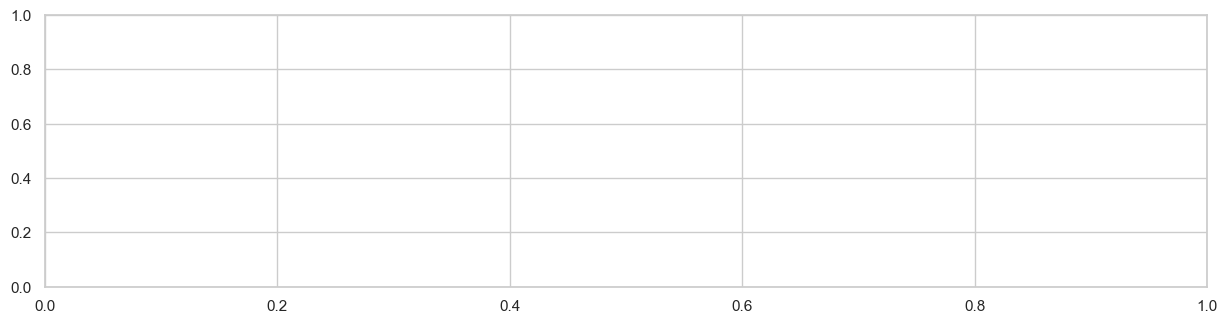

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.gridspec import GridSpec
import calendar

def create_uncertainty_plots(ace_orig, predictions, ensemble_means, ci_lower, ci_upper, 
                           ensemble_stds, uncertainty_analysis, years_total):
    """
    Create a comprehensive suite of plots for uncertainty analysis.
    """
    # Set style for publication-quality figures
    #plt.style.use('seaborn-paper')
    sns.set_palette("deep")
    
    # Create figure with GridSpec for custom layout
    fig = plt.figure(figsize=(15, 12))
    gs = GridSpec(3, 2, figure=fig)
    
    # 1. Time series plot with confidence intervals
    ax1 = fig.add_subplot(gs[0, :])
    months = np.arange(len(ace_orig))
    
    # Plot confidence intervals
    ax1.fill_between(months, ci_lower, ci_upper, alpha=0.3, color='gray', 
                     label='95% Confidence Interval')
    
    # Plot original data and predictions
    ax1.plot(months, ace_orig, 'k-', label='Observed ACE', linewidth=1)
    ax1.plot(months, predictions, 'r-', label='Model Predictions', linewidth=1)
    
    # Customize time series plot
    years = np.arange(1980, 1980 + years_total)  # Adjust start year as needed
    ax1.set_xticks(np.arange(0, len(months), 12))
    ax1.set_xticklabels(years, rotation=45)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('ACE')
    ax1.set_title('ACE Time Series with Ensemble Confidence Intervals')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Seasonal uncertainty patterns
    ax2 = fig.add_subplot(gs[1, 0])
    monthly_uncertainties = uncertainty_analysis['monthly_uncertainties']
    months_labels = [calendar.month_abbr[i] for i in range(1, 13)]
    
    sns.barplot(x=months_labels, y=monthly_uncertainties, ax=ax2)
    ax2.set_title('Seasonal Pattern of Prediction Uncertainty')
    ax2.set_xlabel('Month')
    ax2.set_ylabel('Average Uncertainty (Std)')
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Uncertainty vs ACE magnitude scatter plot
    ax3 = fig.add_subplot(gs[1, 1])
    corr, p_value = uncertainty_analysis['ace_uncertainty_correlation']
    
    ax3.scatter(ace_orig, ensemble_stds, alpha=0.5)
    ax3.set_xlabel('Observed ACE')
    ax3.set_ylabel('Prediction Uncertainty (Std)')
    ax3.set_title(f'Uncertainty vs ACE Magnitude\nr = {corr:.3f}, p = {p_value:.3e}')
    
    # Add trend line
    z = np.polyfit(ace_orig, ensemble_stds, 1)
    p = np.poly1d(z)
    ax3.plot(ace_orig, p(ace_orig), "r--", alpha=0.8)
    
    # 4. Uncertainty by ACE range
    ax4 = fig.add_subplot(gs[2, 0])
    uncertainty_by_range = uncertainty_analysis['uncertainty_by_range']
    
    ranges = ['low', 'mid_low', 'mid_high', 'high']
    uncertainties = [uncertainty_by_range[r] for r in ranges]
    
    sns.barplot(x=ranges, y=uncertainties, ax=ax4)
    ax4.set_title('Average Uncertainty by ACE Range')
    ax4.set_xlabel('ACE Range')
    ax4.set_ylabel('Average Uncertainty (Std)')
    
    # 5. Uncertainty distribution
    ax5 = fig.add_subplot(gs[2, 1])
    sns.histplot(ensemble_stds, kde=True, ax=ax5)
    ax5.set_title('Distribution of Prediction Uncertainty')
    ax5.set_xlabel('Uncertainty (Std)')
    ax5.set_ylabel('Count')
    
    # Adjust layout
    plt.tight_layout()
    return fig

# Generate the plots
fig = create_uncertainty_plots(
    ace_orig,
    predictions,
    ensemble_means,
    ci_lower,
    ci_upper,
    ensemble_stds,
    uncertainty_analysis,
    years_total
)

# Save the figure
plt.savefig('uncertainty_analysis.png', dpi=300, bbox_inches='tight')
plt.close()

# Create additional detail plot for the most recent decade
def plot_recent_decade(ace_orig, predictions, ci_lower, ci_upper, years_total):
    plt.figure(figsize=(12, 6))
    
    # Select last 120 months (10 years)
    last_n = 120
    months = np.arange(-last_n, 0)
    
    plt.fill_between(months, ci_lower[-last_n:], ci_upper[-last_n:], 
                     alpha=0.3, color='gray', label='95% Confidence Interval')
    plt.plot(months, ace_orig[-last_n:], 'k-', label='Observed ACE', linewidth=1)
    plt.plot(months, predictions[-last_n:], 'r-', label='Model Predictions', linewidth=1)
    
    # Customize plot
    years = np.arange(1980 + years_total - 10, 1980 + years_total)  # Adjust as needed
    plt.xticks(np.arange(-120, 1, 12), years, rotation=45)
    plt.xlabel('Year')
    plt.ylabel('ACE')
    plt.title('Detailed View of Last Decade with Prediction Uncertainty')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('recent_decade_uncertainty.png', dpi=300, bbox_inches='tight')
    plt.close()

# Generate the recent decade plot
plot_recent_decade(ace_orig.flatten(), predictions, ci_lower, ci_upper, years_total)

In [ ]:
ensemble_means.shape

In [ ]:
ensemble_stds.shape

In [ ]:
ace_orig.shape